In [2]:
import sys
sys.path.append('/home1/dscho/code/projects/manning_replication')
import os
import glob
import pickle
from time import time
from time import strftime
import random
import itertools
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
from collections import OrderedDict
from importlib import reload

import numpy as np
import pandas as pd
#import xarray as xr
import scipy.io as sio
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
import scipy.signal as signal
import statsmodels.api as sm
 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
#from mpl_toolkits.mplot3d import Axes3D
#import plotly.plotly as py
#import plotly.graph_objs as go
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'medium'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
from cluster_helper.cluster import cluster_view
from ptsa.data.TimeSeriesX import TimeSeries 
#from ptsa.data.filters import MorletWaveletFilter
#from ptsa.data.filters import ButterworthFilter
#from ptsa.data.filters import MonopolarToBipolarMapper
import manning_utils
import manning_analysis
from eeg_plotting import plot_trace

In [3]:
## Setup project.
dirs, subj_info, config, subj_df, subj_df_file = manning_analysis.setup_session()
data_dir = dirs['data']
epoch_dir = os.path.join(data_dir, 'epoch')
figure_dir = dirs['figs']
sessions = subj_df.groupby('subj_sess').mean().index.tolist()

# Figure out which subjects have dataframes in metadata.
files = glob.glob(os.path.join(data_dir, 'metadata', 'subj_df_*.xlsx'))
sessions = []
for f in sorted(files):
    subj_sess = os.path.basename(f)[8:os.path.basename(f).index('.xlsx')]
    sessions.append(subj_sess)
print('{} sessions'.format(len(sessions)))

subj_df = pd.read_excel(files[0], converters={'chan': str})
for f in files[1:]:
    subj_df = subj_df.append(pd.read_excel(f, converters={'chan': str}))
    
# Get a dictionary of all channels with 1+ units.
spike_chans = OrderedDict(subj_df.loc[subj_df.n_clusters>0][['subj_sess', 'chan']].groupby('subj_sess').chan.apply(list))

Loading subjects DataFrame: /data3/scratch/dscho/frLfp/data/subj_df.xlsx

There are 20 subjects, 46 sessions, and 2944 channels in the study.

46 sessions will be processed: ['U367_env2', 'U369_env1', 'U369_env2', 'U370_env1', 'U371_env1', 'U371_env2', 'U371_env3', 'U372_ses1', 'U372_ses2', 'U373_ses1', 'U373_ses2', 'U373_ses3', 'U374_ses1', 'U374_ses2', 'U379_ses1', 'U380_ses1a', 'U380_ses2', 'U380_ses3', 'U381_ses1', 'U381_ses2', 'U381_ses3', 'U384_ses1', 'U384_ses2', 'U384_ses3', 'U385_ses1', 'U385_ses2', 'U385_ses3', 'U385_ses4', 'U386_ses1', 'U386_ses2', 'U387_ses1', 'U387_ses2', 'U387_ses3', 'U390_ses1', 'U390_ses2', 'U390_ses3', 'U390_ses4', 'U392_ses1', 'U393_ses2', 'U394_ses1', 'U394_ses3', 'U395_ses1', 'U395_ses2', 'U395_ses3', 'U396_ses2', 'U396_ses3']
0 sessions have missing input files and will not be processed.

46 sessions


In [4]:
# Load channels that will be used in the virtual electrode analysis.
with open(os.path.join(data_dir, 'other', 'keep_chans.pkl'), 'rb') as f:
    keep_chans = pickle.load(f)

## Make virtual electrodes

In [63]:
# Make virtual electrodes.
# For each region, Z-score processed LFP values for each channel
# in the region, and then create a virtual electrode as the
# average Z-scored voltage across channels, at each timepoint.
start = time()
sessions = sorted(keep_chans.keys())
n_rois = 0
for subj_sess in sessions:
    for roi in keep_chans[subj_sess].keys():
        n_rois += 1
print('{} regions will be processsed.'.format(n_rois))

for subj_sess in sessions:
    rois = sorted(keep_chans[subj_sess].keys())
    lfp = TimeSeries.from_hdf(os.path.join(data_dir, 'lfp', '{}_notch-filtered_spikes-interpolated.hdf'.format(subj_sess)))
    vlfp = []
    roi_chans = OrderedDict()
    for roi in rois:
        chans = keep_chans[subj_sess][roi]
        roi_chans[roi] = chans
        lfp_roi = lfp.sel(channel=chans)
        lfp_roi_z = (lfp_roi - lfp_roi.mean(dim='time')) / lfp_roi.std(dim='time')
        vlfp.append(lfp_roi_z.mean(dim='channel').data)
    
    vlfp = TimeSeries(np.array(vlfp), 
                      name=subj_sess,
                      dims=['region', 'time'],
                      coords={'region': rois,      
                              'time': lfp.time.data,
                              'samplerate': float(lfp.samplerate.data)},
                      attrs={'chans': roi_chans})
    f = os.path.join(data_dir, 'virtual_lfp', '{}_virtual_lfp.hdf'.format(subj_sess))
    vlfp.to_hdf(f)
    
print('Done in {:.0f} secs'.format(time() - start))

266 regions will be processsed.
Done in 438 secs


In [9]:
#subj_sess, roi = random_subjroi(spike_rois)
subj_sess = 'U369_env1'
rois = sorted(keep_chans[subj_sess].keys())
roi = rois[0]
print(subj_sess, roi)

lfp = TimeSeries.from_hdf(os.path.join(data_dir, 'lfp', '{}_notch-filtered_spikes-interpolated.hdf'.format(subj_sess)))
chans = keep_chans[subj_sess][roi]
lfp_roi = lfp.sel(channel=chans)
lfp_roi_z = (lfp_roi - lfp_roi.mean(dim='time')) / lfp_roi.std(dim='time')

vlfp = TimeSeries.from_hdf(os.path.join(data_dir, 'virtual_lfp', '{}_virtual_lfp.hdf'.format(subj_sess)))
vlfp_roi = vlfp.sel(region=[roi])

U369_env1 LA


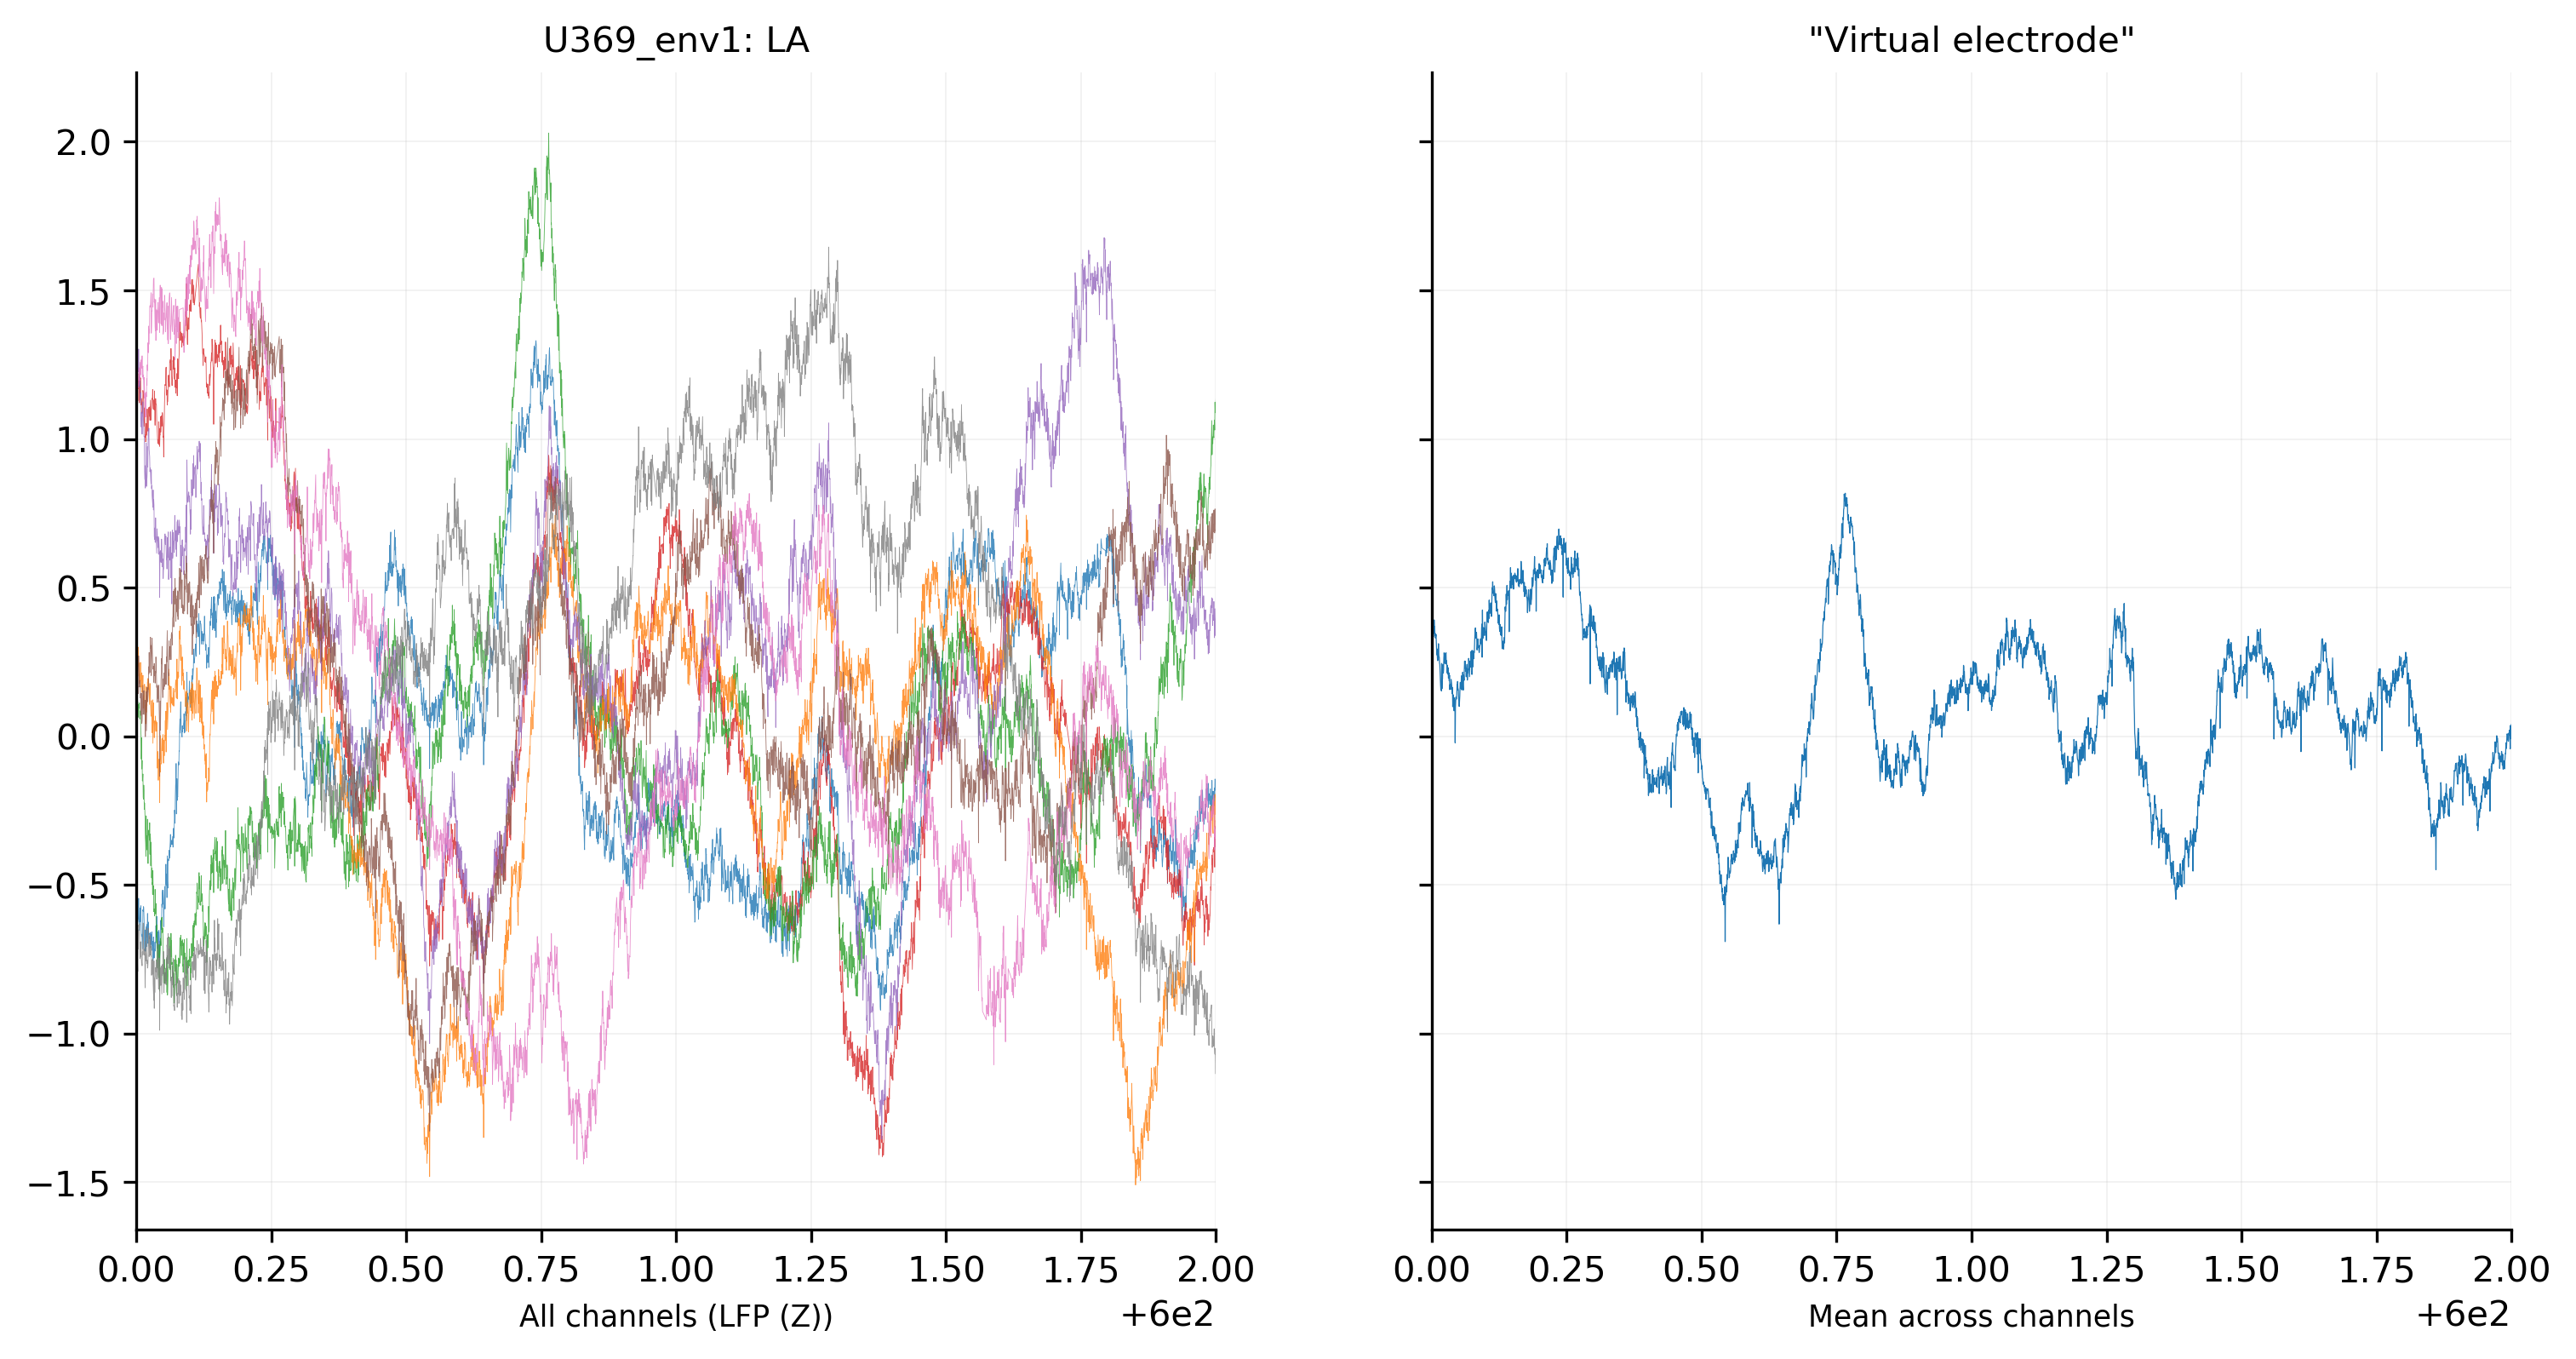

In [16]:
start = 600
duration = 2

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6), dpi=300)
ax = np.ravel(ax)

plot_trace(vlfp_roi, start=start, duration=duration, x_lab='Mean across channels', 
           x_units='secs', fig=fig, ax=ax[1], title='"Virtual electrode"')

plot_trace(lfp_roi_z, start=start, duration=duration, x_units='secs', x_lab='All channels (LFP (Z))', 
           linewidths=[0.2]*len(lfp_roi_z), alphas=[0.8]*len(lfp_roi_z),
           fig=fig, ax=ax[0], title='{}: {}'.format(subj_sess, roi))

f = os.path.join(figure_dir, 'virtual_electrode_construction_{}_{}.png'.format(subj_sess, roi))
fig.savefig(f)

In [ ]:
# PROCESS POWER FOR ALL VIRTUAL ELECTRODES!
start = time()
freqs = np.logspace(np.log10(2), np.log10(200), 50, base=10)
for subj_sess in sessions[1:]:
    vlfp = TimeSeries.from_hdf(os.path.join(data_dir, 'virtual_lfp', '{}_virtual_lfp.hdf'.format(subj_sess)))
    for roi in vlfp.region.data:
        power_file = os.path.join(data_dir, 'virtual_lfp', 'morlet', 
                                  '{}_{}_power_width5_2-200Hz-50log10steps.hdf'
                                  .format(subj_sess, roi))
        power, phase = manning_analysis.run_morlet(vlfp.sel(region=[roi]), 
                                                   freqs=freqs,
                                                   width=5,
                                                   log_power=False,
                                                   z_power=False,
                                                   power_file=power_file,
                                                   overwrite=False)
        
print('Done in {:.0f} secs'.format(time() - start))

CPP total time wavelet loop:  14.691561937332153
CPP total time wavelet loop:  15.421533107757568
CPP total time wavelet loop:  13.654921531677246


In [214]:
# Sanity check power measures against filtered LFP. 
subj_sess = 'U367_env2'
roi = 'RTG'

vlfp = TimeSeries.from_hdf(os.path.join(data_dir, 'virtual_lfp', '{}_virtual_lfp.hdf'.format(subj_sess)))
power_file = os.path.join(data_dir, 'virtual_lfp', 'morlet', 
                                  '{}_{}_power_width5_2-200Hz-50log10steps.hdf'
                                  .format(subj_sess, roi))
power = TimeSeries.from_hdf(power_file)

theta = power.sel(frequency=((power.frequency>=4) & (power.frequency<8))).mean('frequency')
logtheta = np.log10(theta)
ztheta = (theta - theta.mean('time')) / theta.std('time')
zlogtheta = (logtheta - logtheta.mean('time')) / logtheta.std('time')
vlfptheta = mne.filter.filter_data(vlfp.sel(region=[roi]).data, sfreq=2000, l_freq=2, h_freq=4)

gamma = power.sel(frequency=((power.frequency>=30) & (power.frequency<60))).mean('frequency')
loggamma = np.log10(gamma)
zgamma = (gamma - gamma.mean('time')) / gamma.std('time')
zloggamma = (loggamma - loggamma.mean('time')) / loggamma.std('time')
vlfpgamma = mne.filter.filter_data(vlfp.sel(region=[roi]).data, sfreq=2000, l_freq=30, h_freq=60)

Setting up band-pass filter from 2 - 4 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 3301 samples (1.651 sec) selected
Setting up band-pass filter from 30 - 60 Hz
l_trans_bandwidth chosen to be 7.5 Hz
h_trans_bandwidth chosen to be 15.0 Hz
Filter length of 881 samples (0.441 sec) selected


U367_env2 RTG


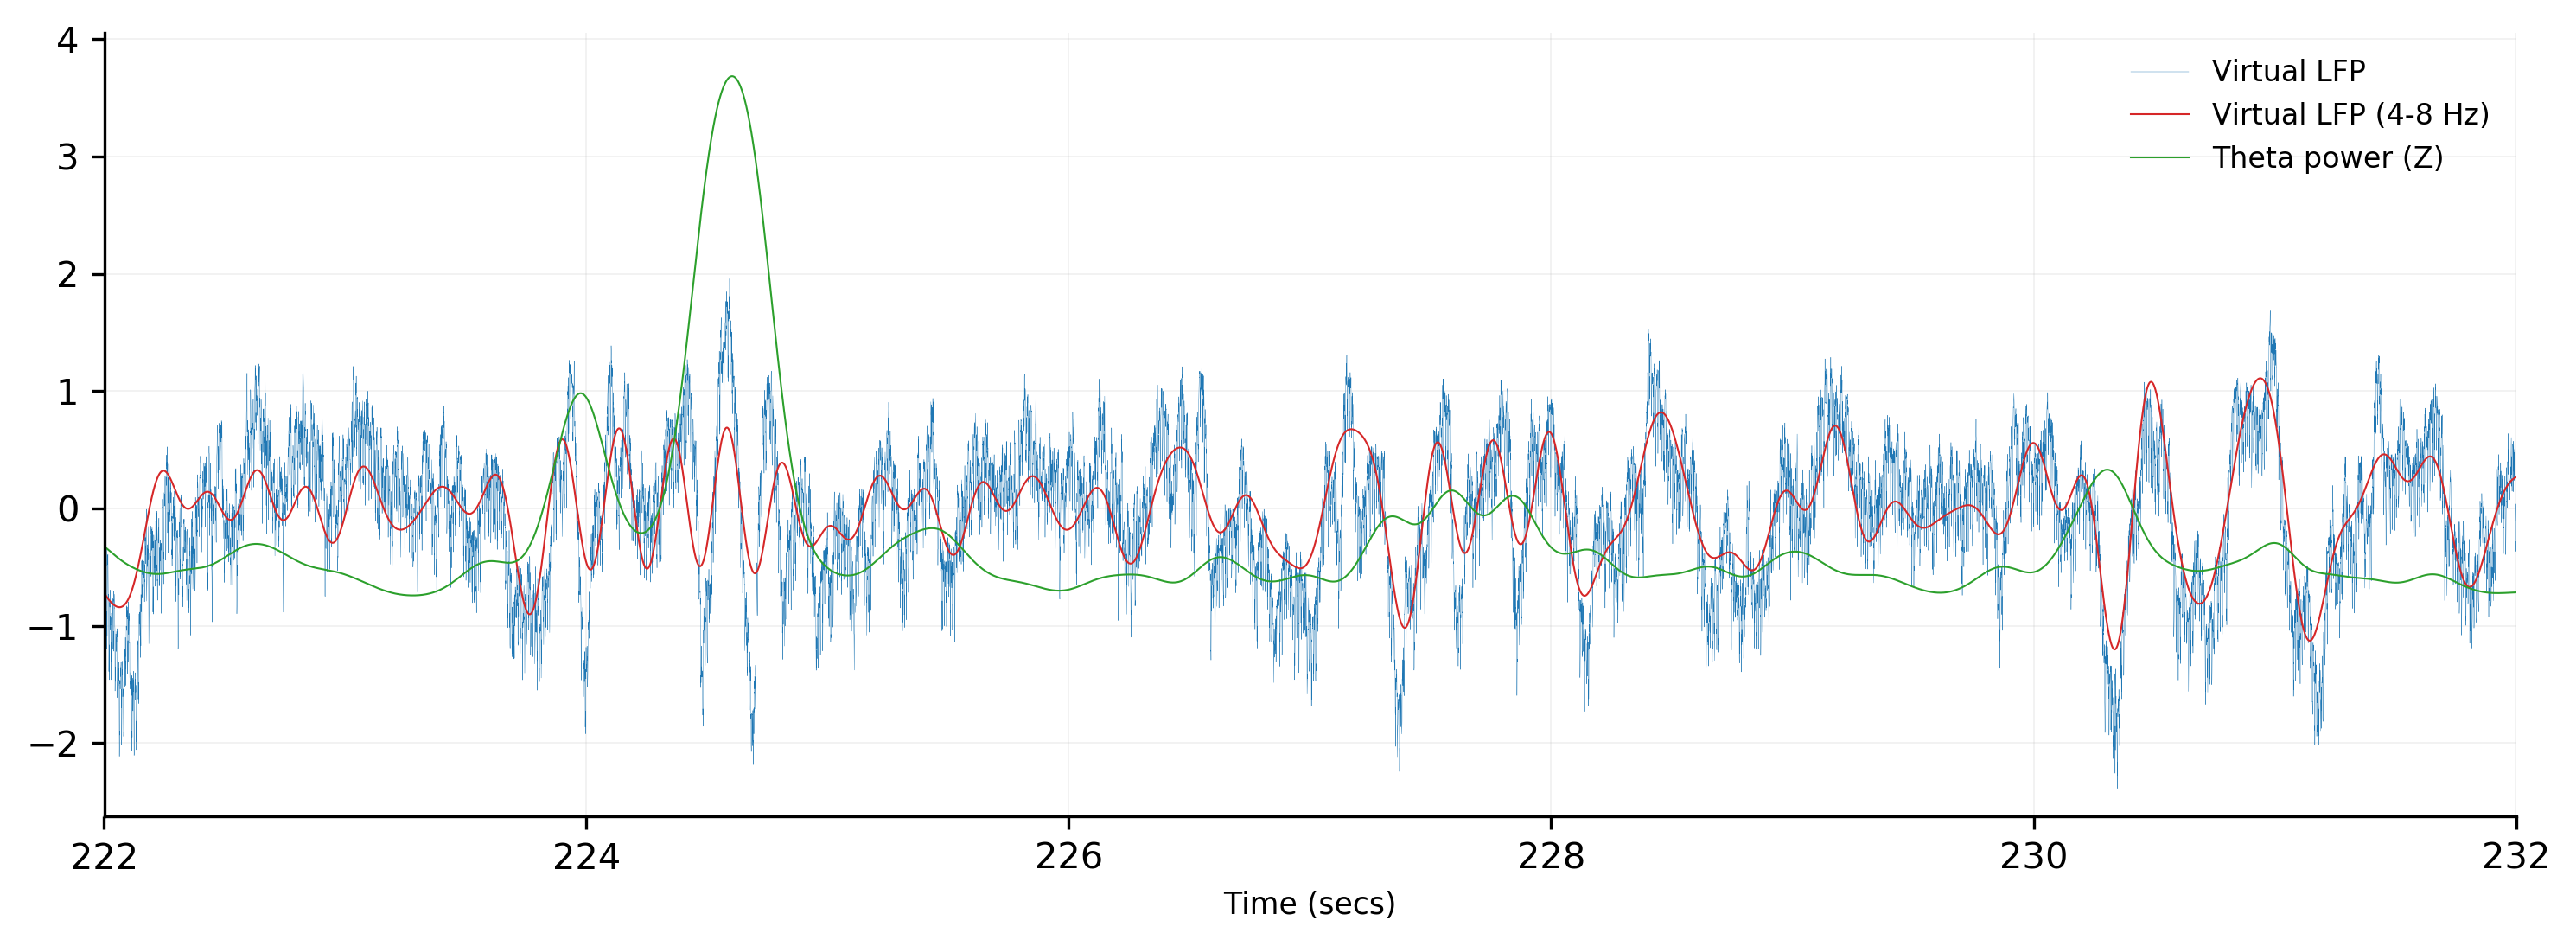

In [219]:
print(subj_sess, roi)
dat = np.vstack((vlfp.sel(region=[roi]).data,
                 vlfptheta,
                 ztheta.data))
fig, ax = plot_trace(dat, start=222, duration=10, x_units='secs', 
                     linewidths=[0.1, 0.5, 0.5],
                     legend_labels=['Virtual LFP', 'Virtual LFP (4-8 Hz)', 'Theta power (Z)'],
                     dpi=300)

f = os.path.join(figure_dir, 'virtual_LFP_theta_power_example_{}_{}.png'.format(subj_sess, roi))
#fig.savefig(f)

U367_env2 RTG


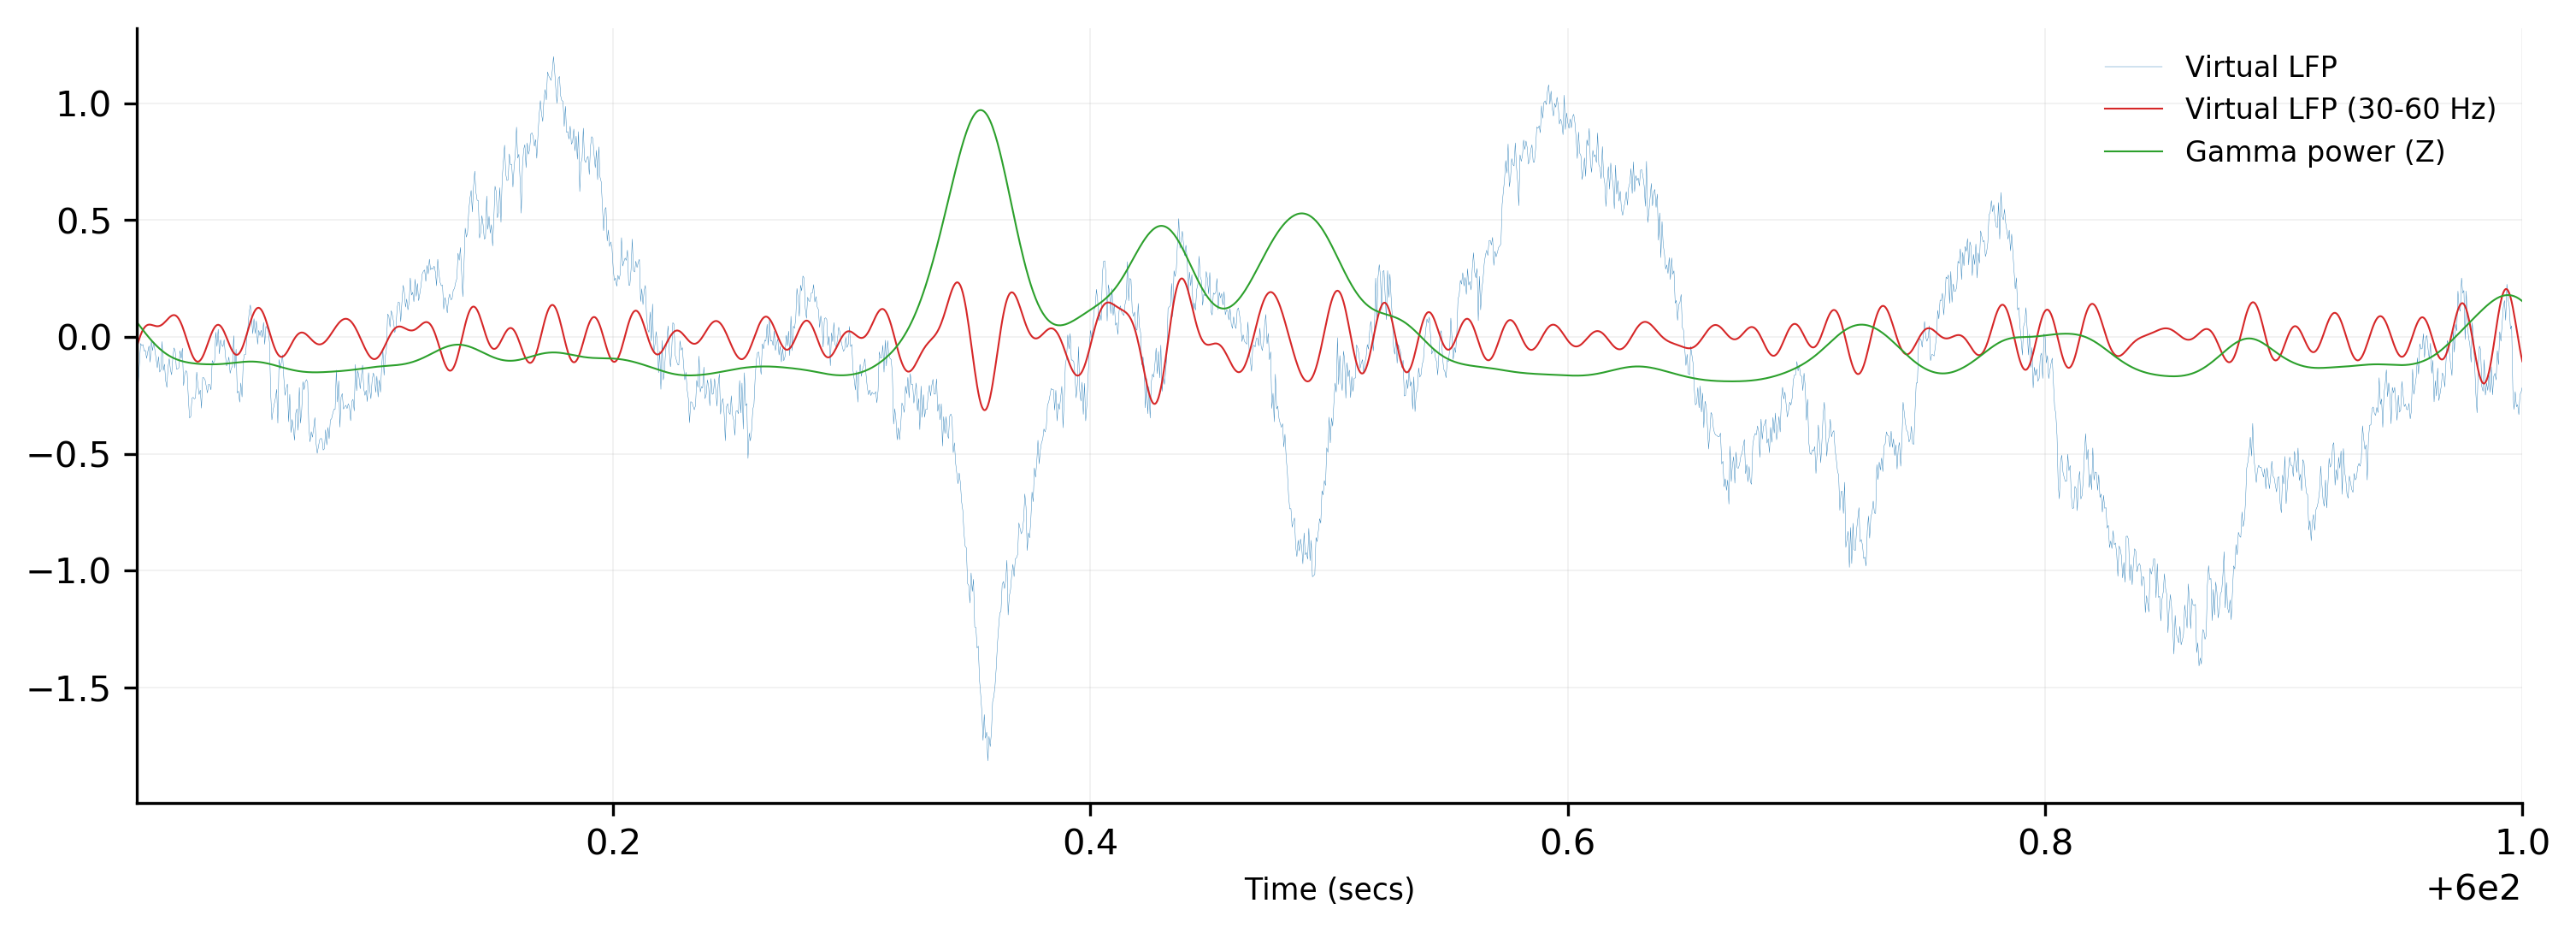

In [220]:
print(subj_sess, roi)
dat = np.vstack((vlfp.sel(region=[roi]).data,
                 vlfpgamma,
                 zgamma.data))
fig, ax = plot_trace(dat, start=600, duration=1, x_units='secs', 
                     linewidths=[0.1, 0.5, 0.5],
                     legend_labels=['Virtual LFP', 'Virtual LFP (30-60 Hz)', 'Gamma power (Z)'],
                     dpi=300)

f = os.path.join(figure_dir, 'virtual_LFP_gamma_power_example_{}_{}.png'.format(subj_sess, roi))
#fig.savefig(f)

## Make virtual electrodes from non-spiking channels

In [6]:
# Make virtual electrodes from channels with no units recorded.
# For each region, Z-score processed LFP values for each channel
# in the region, and then create a virtual electrode as the
# average Z-scored voltage across channels, at each timepoint.
sessions = sorted(keep_chans.keys())
save_outputs = False

# After removing spiking channels, find regions with at least
# 2 channels left to make a virtual electrode out of.
keep_chans_nospikes = OrderedDict()
for subj_sess in sessions:
    rois = sorted(keep_chans[subj_sess].keys())
    roi_chans = OrderedDict()
    for roi in rois:
        chans = [chan for chan in keep_chans[subj_sess][roi] if chan not in spike_chans[subj_sess]]
        if len(chans) >= 2:
            keep_chans_nospikes.setdefault(subj_sess, OrderedDict())[roi] = chans

n_chans = []
for subj_sess in sorted(keep_chans_nospikes.keys()):
    for roi in sorted(keep_chans_nospikes[subj_sess].keys()):
        n_chans.append(len(keep_chans_nospikes[subj_sess][roi]))
n_chans = np.sort(n_chans)

if save_outputs:
    with open(os.path.join(data_dir, 'other', 'keep_chans_nospikes.pkl'), 'wb') as f:
        pickle.dump(keep_chans_nospikes, f, pickle.HIGHEST_PROTOCOL)

print('No-spike virtual LFP subset: {} subjs, {} regions, {} channels.'.format(len(keep_chans_nospikes), len(n_chans), np.sum(n_chans)))
print(np.min(n_chans), np.percentile(n_chans, 25), np.median(n_chans), np.percentile(n_chans, 75), np.max(n_chans))

No-spike virtual LFP subset: 45 subjs, 176 regions, 631 channels.
2 2.0 3.0 5.0 6


In [266]:
# Make virtual electrodes.   
start = time()
for subj_sess in sorted(keep_chans_nospikes.keys()):
    rois = sorted(keep_chans_nospikes[subj_sess].keys())
    lfp = TimeSeries.from_hdf(os.path.join(data_dir, 'lfp', '{}_notch-filtered_spikes-interpolated.hdf'.format(subj_sess)))
    vlfp = []
    roi_chans = OrderedDict()
    for roi in rois:
        chans = keep_chans_nospikes[subj_sess][roi]
        roi_chans[roi] = chans
        lfp_roi = lfp.sel(channel=chans)
        lfp_roi_z = (lfp_roi - lfp_roi.mean(dim='time')) / lfp_roi.std(dim='time')
        vlfp.append(lfp_roi_z.mean(dim='channel').data)
    
    vlfp = TimeSeries(np.array(vlfp), 
                      name=subj_sess,
                      dims=['region', 'time'],
                      coords={'region': rois,      
                              'time': lfp.time.data,
                              'samplerate': float(lfp.samplerate.data)},
                      attrs={'chans': roi_chans})
    f = os.path.join(data_dir, 'virtual_lfp_nospikes', '{}_virtual_lfp.hdf'.format(subj_sess))
    vlfp.to_hdf(f)
    
print('Done in {:.0f} secs'.format(time() - start))

Done in 385 secs


In [ ]:
# PROCESS POWER FOR ALL VIRTUAL ELECTRODES!
epoch_rates = [10, 2, 1, 0.5, 0.2]
freqs = np.logspace(np.log10(2), np.log10(200), 50, base=10)

start = time()
for subj_sess in sorted(keep_chans_nospikes.keys()):
    vlfp = TimeSeries.from_hdf(os.path.join(data_dir, 'virtual_lfp_nospikes', '{}_virtual_lfp.hdf'.format(subj_sess)))
    for roi in vlfp.region.data:
        power_file = os.path.join(data_dir, 'virtual_lfp_nospikes', 'morlet', 
                                  '{}_{}_power_width5_2-200Hz-50log10steps.hdf'
                                  .format(subj_sess, roi))
        if os.path.exists(power_file):
            power = TimeSeries.from_hdf(power_file).squeeze() # frequency x time
        else:
            power = manning_analysis.run_morlet(vlfp.sel(region=[roi]), 
                                                freqs=freqs,
                                                width=5,
                                                output='power',
                                                log_power=False,
                                                z_power=False,
                                                savedir=None)
            power = power.squeeze()
            
        powerdat = power.data
        n_timepoints = len(power.time)
        sampling_rate = float(power.samplerate)
        
        for epoch_rate in epoch_rates:
            cut = int(np.ceil((sampling_rate*1.5) / (sampling_rate/epoch_rate)))

            # Get time bins, cutting the first and last 1.5secs of data.
            time_bins = manning_utils.get_epochs(np.arange(n_timepoints), epoch_size=(sampling_rate/epoch_rate), cut=cut)

            # Epoch the power data.
            epower = []
            for start, stop in time_bins:
                epower.append(np.mean(powerdat[:, start:stop], axis=1))
            epower = TimeSeries(np.array(epower), name=power.name, 
                                dims=['epoch', 'frequency'],
                                coords={'epoch': np.arange(len(time_bins)), 
                                        'frequency': power.frequency.data,
                                        'samplerate': epoch_rate},
                                attrs={'region': str(power.region.data),
                                       'lfp_start_stop': [time_bins[0][0], time_bins[-1][1]],
                                       'morlet_width': power.morlet_width})

            epoch_power_file = os.path.join(data_dir, 'virtual_lfp_nospikes', 'morlet', 
                                            '{}_{}_power_width5_2-200Hz-50log10steps_{}Hz-epochs.hdf'.format(subj_sess, roi, epoch_rate))
            epower.to_hdf(epoch_power_file)
        
        # Remove the large power file.
        if os.path.exists(power_file):
            os.remove(power_file)
        
print('Done in {:.0f} secs'.format(time() - start))

CPP total time wavelet loop:  6.778990030288696
CPP total time wavelet loop:  6.380990743637085
CPP total time wavelet loop:  6.60351300239563
CPP total time wavelet loop:  6.669638156890869
CPP total time wavelet loop:  6.5059425830841064
CPP total time wavelet loop:  7.799843072891235
CPP total time wavelet loop:  6.718839645385742
CPP total time wavelet loop:  6.723588705062866
CPP total time wavelet loop:  6.699130535125732
CPP total time wavelet loop:  6.430263519287109
CPP total time wavelet loop:  6.155738592147827
CPP total time wavelet loop:  7.138604402542114
CPP total time wavelet loop:  6.967263460159302
CPP total time wavelet loop:  7.388880014419556
CPP total time wavelet loop:  6.881962537765503
CPP total time wavelet loop:  6.743718862533569
CPP total time wavelet loop:  7.376822471618652
CPP total time wavelet loop:  14.026412963867188


(<Figure size 1800x600 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2acbbeb3c390>],
       dtype=object))

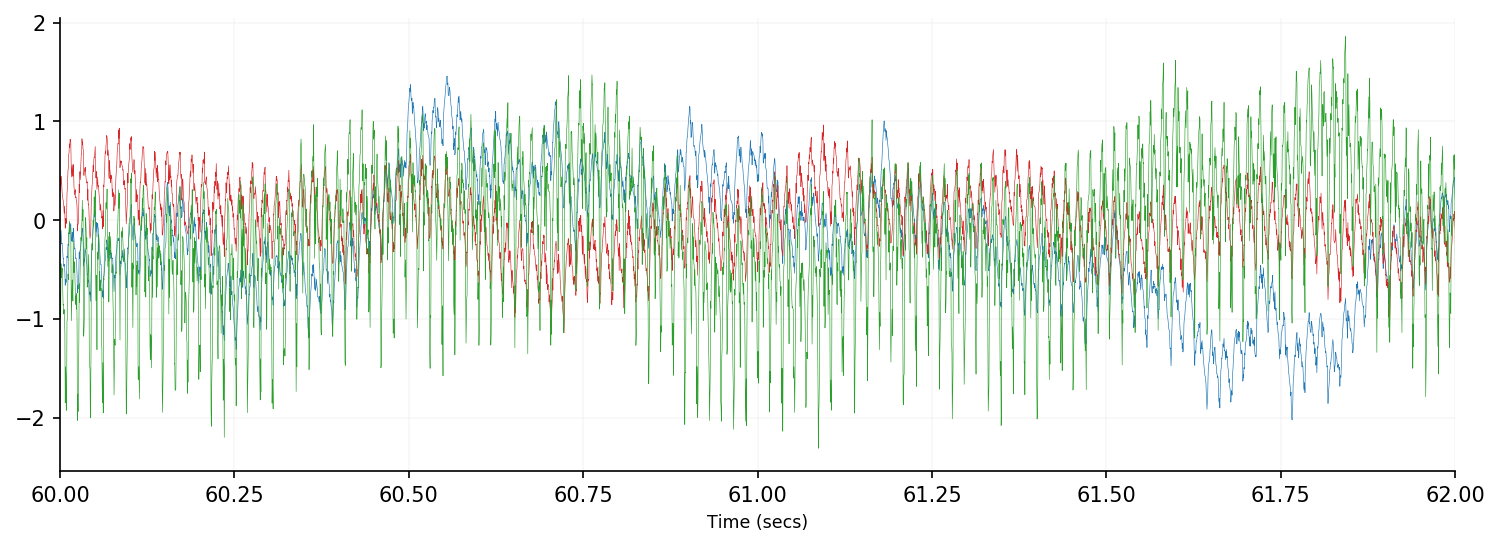

In [264]:
plot_trace(vlfp, start=60, duration=2, x_units='secs', legend_labels=vlfp.region.data)

## Older

In [19]:
keep_chans[subj_sess]

OrderedDict([('LEC', ['25', '26', '27', '28', '29', '30', '31', '32']),
             ('LMH', ['41', '42', '43', '44', '45', '46', '47', '48']),
             ('LOF', ['1', '2', '3', '4', '5', '6', '7', '8']),
             ('RAH', ['49', '50', '51', '52', '53', '54', '55', '56'])])

In [387]:
print('{} units in total.'.format(np.sum(subj_df.groupby(['location']).n_clusters.sum())))
#subj_df.groupby(['subj_sess']).n_clusters.sum()
#subj_df.groupby(['location']).n_clusters.sum()

1831 units in total.


In [20]:
start = time()
# interp_masks[subj_sess][roi] contains an n_channel x n_timepoints
# array of timepoints interpolated to remove spikes from the LFP
interp_masks = OrderedDict()
# interp_freqs is an n_region x 9 array that contains the
# interpolation frequencies for each region with 1+ units,
# across all sessions.
interp_freqs = []
spike_rois = OrderedDict()
missing_rois = OrderedDict()
for subj_sess in sorted(keep_chans.keys()):
    interp_masks[subj_sess] = OrderedDict()
    subj_df_ = subj_df.loc[subj_df.subj_sess==subj_sess]
    loc_to_chan = OrderedDict(subj_df_.groupby('location', sort=False).chan.apply(list))
    with open(os.path.join(data_dir, 'spikes', '{}_session_spikes.pkl'.format(subj_sess)), 'rb') as f:
        spikes = pickle.load(f)
    if type(list(spikes.keys())[0]) == str:
        str_chans = True
    else:
        str_chans = False
    n_timepoints = spikes[list(spikes.keys())[0]]['fr'].shape[1]
    rois = sorted(keep_chans[subj_sess].keys())
    for roi in rois:
        # Stack interp_mask vectors for all channels in each region.
        interp_masks[subj_sess][roi] = []
        chans = keep_chans[subj_sess][roi]
        for chan in chans:
            try:
                if str_chans:
                    interp_masks[subj_sess][roi].append(spikes[chan]['interp_mask'])
                else:
                    interp_masks[subj_sess][roi].append(spikes[int(chan)]['interp_mask'])
            except:
                interp_masks[subj_sess][roi].append(np.zeros(n_timepoints, dtype='bool_'))
                
        interp_masks[subj_sess][roi] = np.array(interp_masks[subj_sess][roi])
        
        # Get the sum of interpolated values at each timepoint, across
        # all channels for a given region (will be 0-8). Then figure out
        # the frequency of each interpolation sum across timepoints (e.g.
        # what percent of the time are we interpolating 6/8 channels?)
        # Ignore regions where no units were recorded.
        if np.all(np.invert(interp_masks[subj_sess][roi])):
            if subj_sess in missing_rois:
                missing_rois[subj_sess].append(roi)
            else:
                missing_rois[subj_sess] = [roi]
        else:
            if subj_sess in spike_rois:
                spike_rois[subj_sess].append(roi)
            else:
                spike_rois[subj_sess] = [roi]
            unique_vals, counts = np.unique(np.sum(interp_masks[subj_sess][roi], axis=0), return_counts=True)
            freq = counts / interp_masks[subj_sess][roi].shape[1]
            for val in range(9):
                if val not in unique_vals:
                    unique_vals = np.append(unique_vals, val)
                    freq = np.append(freq, 0.)
            xsort = np.argsort(unique_vals)
            freq = freq[xsort]
            interp_freqs.append(freq)
interp_freqs = np.array(interp_freqs)    
print('Done in {:.0f} secs'.format(time() - start))

Done in 82 secs


In [24]:
counts, len(chans)

(array([2957748,   52298,     158]), 8)

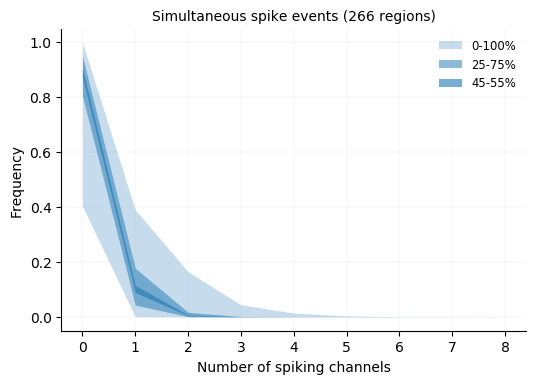

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax = np.ravel(ax)
ax[0].fill_between(np.arange(9), 
                   np.percentile(interp_freqs, 0, axis=0),
                   np.percentile(interp_freqs, 100, axis=0),
                   color='C0', alpha=0.25, linewidth=0, label='0-100%')
ax[0].fill_between(np.arange(9), 
                   np.percentile(interp_freqs, 25, axis=0),
                   np.percentile(interp_freqs, 75, axis=0),
                   color='C0', alpha=0.5, linewidth=0, label='25-75%')
ax[0].fill_between(np.arange(9), 
                   np.percentile(interp_freqs, 45, axis=0),
                   np.percentile(interp_freqs, 55, axis=0),
                   color='C0', alpha=0.6, linewidth=0, label='45-55%')
ax[0].set_xlabel('Number of spiking channels', fontsize=10)
ax[0].set_ylabel('Frequency', fontsize=10)
ax[0].legend()
ax[0].set_title(('Simultaneous spike events ({} regions)'.format(len(interp_freqs))))
f = os.path.join(figure_dir, 'frequency_of_simultaneous_spiking_across_channels_in_a_region.png')
#fig.savefig(f)

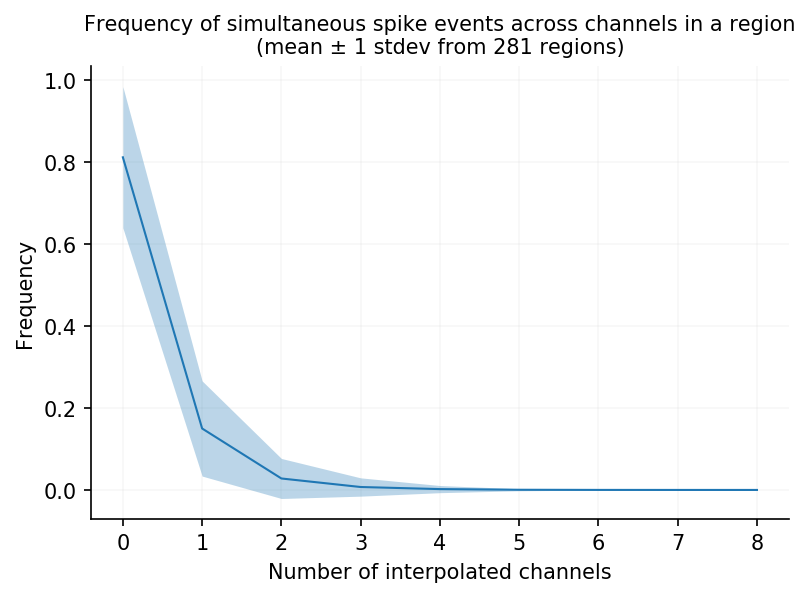

In [317]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
ax = np.ravel(ax)
ax[0].fill_between(np.arange(9), 
                   np.mean(interp_freqs, axis=0) - np.std(interp_freqs, axis=0),
                   np.mean(interp_freqs, axis=0) + np.std(interp_freqs, axis=0),
                   color='C0', alpha=0.3, linewidth=0)
ax[0].plot(np.arange(9), np.mean(interp_freqs, axis=0), linewidth=1, color='C0')
ax[0].set_xlabel('Number of interpolated channels', fontsize=10)
ax[0].set_ylabel('Frequency', fontsize=10)
ax[0].set_title(('Frequency of simultaneous spike events across channels in a region\n' +
                  '(mean ± 1 stdev from {} regions)'.format(interp_freqs.shape[0])))
f = os.path.join(figure_dir, 'frequency_of_simultaneous_spiking_across_channels_in_a_region.png')
#fig.savefig(f)

In [368]:
# Get correlations between firing rate vectors for channels within a region
# versus for equal numbers of randomly paired channels within a session.
start = time()

fr_wroi_corrs = OrderedDict()
fr_broi_corrs = []

for subj_sess in sessions:
    subj_df_ = subj_df.loc[subj_df.subj_sess==subj_sess]
    loc_to_chan = OrderedDict(subj_df_.groupby('location', sort=False).chan.apply(list))
    
    # Load spikes.
    with open(os.path.join(data_dir, 'spikes', '{}_session_spikes.pkl'.format(subj_sess)), 'rb') as f:
        spikes_ = pickle.load(f)
    spikes = OrderedDict()
    for key, value in spikes_.items():
        spikes[str(key)] = value
    spike_chans = list(spikes.keys())
    
    # Get all between-region channel pairs
    # for channels with 1+ units.
    loc_to_chan_mat = []
    for key, vals in loc_to_chan.items():
        if key != 'none':
            row_vals = [chan for chan in vals if chan in spike_chans]
            if row_vals:
                loc_to_chan_mat.append(row_vals)
    broi_chan_pairs = []
    for xy in list(itertools.combinations(range(len(loc_to_chan_mat)), 2)):
        x, y = xy
        broi_chan_pairs += list(itertools.product(loc_to_chan_mat[x], loc_to_chan_mat[y]))
    
    rois = list(loc_to_chan.keys())
    for roi in rois:
        if roi == 'none':
            continue
        fr_roi = []
        chans = [chan for chan in loc_to_chan[roi] if chan in list(spikes.keys())]
        if len(chans) > 1:
            # Get firing rate correlations between all channels within a region.
            # Channel firing rate is the sum of the 1+ unit firing rates.
            for chan in chans:
                fr_roi.append(np.sum(spikes[chan]['fr'], axis=0))
            fr_roi = np.array(fr_roi)
            new_vals = np.corrcoef(fr_roi)[np.tril_indices(len(chans), k=-1)]
            if roi in fr_wroi_corrs:
                fr_wroi_corrs[roi] = np.append(fr_wroi_corrs[roi], new_vals)
            else:
                fr_wroi_corrs[roi] = new_vals
    
    # Get the correlation for each between-region channel pair.
    for broi_pair in broi_chan_pairs:
        chan1, chan2 = broi_pair
        fr_broi_corrs.append(stats.pearsonr(np.sum(spikes[chan1]['fr'], axis=0), np.sum(spikes[chan2]['fr'], axis=0))[0])
    
fr_broi_corrs = np.array(fr_broi_corrs)

fr_wroi_corrs_flat = []
for roi, vals in fr_wroi_corrs.items():
    fr_wroi_corrs_flat += list(vals)
fr_wroi_corrs_flat = np.array(fr_wroi_corrs_flat)

print('Done in {:.0f} secs'.format(time() - start))

Done in 1023 secs


In [369]:
print(fr_broi_corrs.shape, fr_wroi_corrs_flat.shape)
np.mean(fr_broi_corrs), np.mean(fr_wroi_corrs_flat)

(18112,) (2997,)


(0.03705799215258284, 0.13673686935619764)

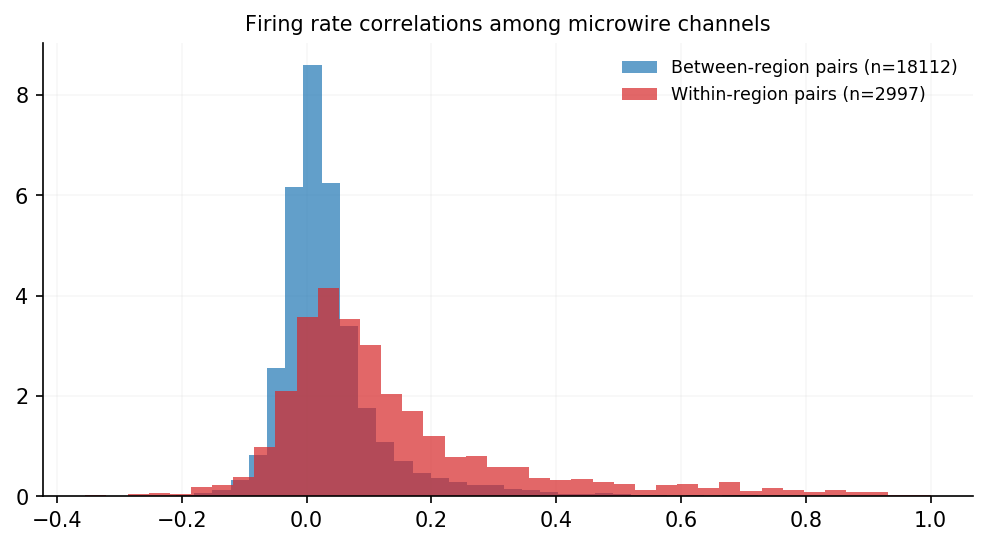

In [376]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)
ax = np.ravel(ax)

ax[0].hist(fr_broi_corrs, density=True, bins=40, color='C0', alpha=0.7, label='Between-region pairs (n={})'.format(len(fr_broi_corrs)))
ax[0].hist(fr_wroi_corrs_flat, density=True, bins=40, color='C1', alpha=0.7, label='Within-region pairs (n={})'.format(len(fr_wroi_corrs_flat)))
ax[0].legend()
ax[0].set_title('Firing rate correlations among microwire channels')

f = os.path.join(figure_dir, 'chan_fr_pair_correlations_within-vs-between-region.png')
#fig.savefig(f)

In [383]:
for key, vals in fr_wroi_corrs.items():
    print('{}: {} pairs, r = {:.02f} ± {:.02f}'.format(key, len(vals), np.mean(fr_wroi_corrs[key]), np.std(fr_wroi_corrs[key])))

RTG: 28 pairs, r = 0.32 ± 0.13
RPH: 28 pairs, r = 0.12 ± 0.13
LA: 464 pairs, r = 0.16 ± 0.23
LPH: 30 pairs, r = 0.17 ± 0.33
LTG: 28 pairs, r = 0.19 ± 0.24
LEC: 192 pairs, r = 0.03 ± 0.08
LAH: 239 pairs, r = 0.15 ± 0.15
RA: 247 pairs, r = 0.16 ± 0.20
RMH: 23 pairs, r = 0.17 ± 0.18
RST: 64 pairs, r = 0.08 ± 0.14
RPS: 56 pairs, r = 0.10 ± 0.09
LMH: 26 pairs, r = 0.18 ± 0.16
LST: 45 pairs, r = 0.28 ± 0.22
RAH: 144 pairs, r = 0.25 ± 0.26
REC: 184 pairs, r = 0.09 ± 0.16
ROF: 225 pairs, r = 0.07 ± 0.12
LOF: 145 pairs, r = 0.07 ± 0.16
LPG: 167 pairs, r = 0.05 ± 0.15
LPO: 38 pairs, r = 0.13 ± 0.11
LSMA: 72 pairs, r = 0.13 ± 0.18
RAC: 125 pairs, r = 0.13 ± 0.17
RSMA: 25 pairs, r = 0.06 ± 0.10
LAC: 69 pairs, r = 0.25 ± 0.23
RpSMA: 31 pairs, r = 0.27 ± 0.18
LpSMA: 28 pairs, r = 0.05 ± 0.06
RMST: 70 pairs, r = 0.05 ± 0.07
RMC: 84 pairs, r = 0.09 ± 0.17
RPST: 6 pairs, r = 0.52 ± 0.20
RPG: 95 pairs, r = 0.36 ± 0.28
RSAO: 3 pairs, r = 0.63 ± 0.05
RPC: 16 pairs, r = 0.07 ± 0.11


In [186]:
# Get correlations between microwire LFPs for channels within a region
# versus for equal numbers of randomly paired channels within a session.
start = time()
lfp_roi_corrs = []
lfp_rand_corrs = []
for subj_sess in sessions:
    subj_df_ = subj_df.loc[subj_df.subj_sess==subj_sess]
    loc_to_chan = OrderedDict(subj_df_.groupby('location', sort=False).chan.apply(list))
    
    # Load LFP data.
    lfp = TimeSeries.from_hdf(os.path.join(data_dir, 'lfp', '{}_notch-filtered_spikes-interpolated.hdf'.format(subj_sess)))
    lfp.channel.data = [str(chan) for chan in lfp.channel.data]
    rois = list(loc_to_chan.keys())
    for roi in rois:
        if not np.all(np.invert(interp_masks[subj_sess][roi])) and not roi == 'none':
            chans = loc_to_chan[roi]
            lfp_roi = lfp.sel(channel=chans)
            lfp_roi_corrs.append(np.corrcoef(lfp_roi)[np.tril_indices(len(chans), k=-1)])
            
            rand_chans = lfp.channel.data[random.sample(range(len(lfp.channel)), len(chans))]
            lfp_rand = lfp.sel(channel=rand_chans)
            lfp_rand_corrs.append(np.corrcoef(lfp_rand)[np.tril_indices(len(chans), k=-1)])

lfp_roi_corrs = np.array(lfp_roi_corrs)
lfp_rand_corrs = np.array(lfp_rand_corrs)
lfp_roi_corrs_flat = []
for roi in lfp_roi_corrs:
    lfp_roi_corrs_flat += list(roi)
lfp_roi_corrs_flat = np.array(lfp_roi_corrs_flat)
    
lfp_rand_corrs_flat = []
for roi in lfp_rand_corrs:
    lfp_rand_corrs_flat += list(roi)
lfp_rand_corrs_flat = np.array(lfp_rand_corrs_flat)

lfp_roi_corrs_wholeroi = []
for roi in lfp_roi_corrs:
    lfp_roi_corrs_wholeroi.append(np.mean(roi))
lfp_roi_corrs_wholeroi = np.array(lfp_roi_corrs_wholeroi)

lfp_rand_corrs_wholeroi = []
for roi in lfp_rand_corrs:
    lfp_rand_corrs_wholeroi.append(np.mean(roi))
lfp_rand_corrs_wholeroi = np.array(lfp_rand_corrs_wholeroi)

print('Done in {:.0f} secs'.format(time() - start))

Done in 217 secs


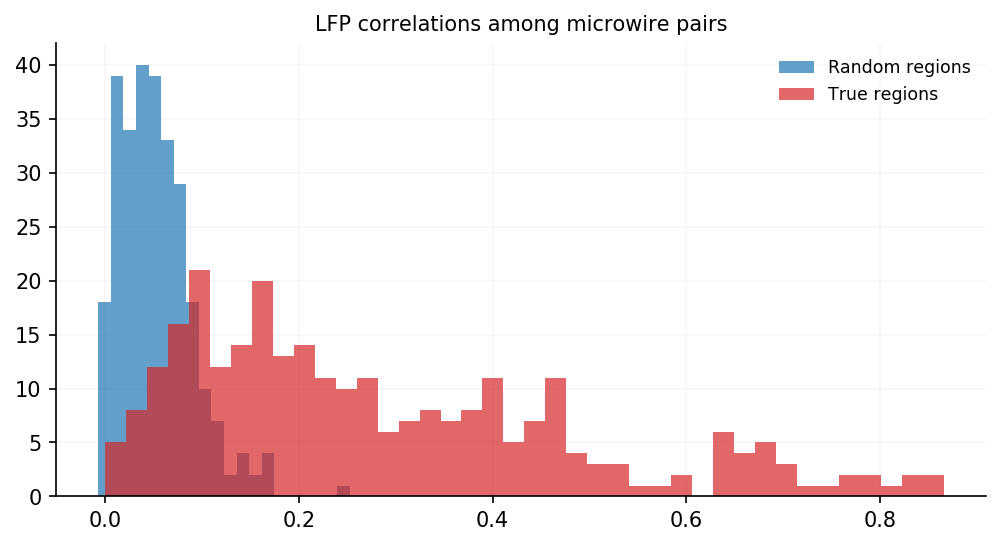

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)
ax = np.ravel(ax)

ax[0].hist(lfp_rand_corrs_wholeroi, density=False, bins=20, color='C0', alpha=0.7, label='Random regions')
ax[0].hist(lfp_roi_corrs_wholeroi, density=False, bins=40, color='C1', alpha=0.7, label='True regions')
ax[0].legend()
ax[0].set_title('LFP correlations among microwire pairs')

f = os.path.join(figure_dir, 'LFP_pair_correlations_within-region_vs_random.png')
#fig.savefig(f)

In [373]:
# Get the average LFP across processed and interpolated, mean-subtracted 
# microwire channels in each region.
start = time()
for subj_sess in sessions:
    subj_df_ = subj_df.loc[subj_df.subj_sess==subj_sess]
    loc_to_chan = OrderedDict(subj_df_.groupby('location', sort=False).chan.apply(list))
    lfp = TimeSeries.from_hdf(os.path.join(data_dir, 'lfp', '{}_notch-filtered_spikes-interpolated.hdf'.format(subj_sess)))
    lfp.channel.data = [str(chan) for chan in lfp.channel.data]
    rois = list(loc_to_chan.keys())
    n_timepoints = len(lfp.time)
    for roi in rois:
        if not np.all(np.invert(interp_masks[subj_sess][roi])):
            chans = loc_to_chan[roi]
            #lfp_roi = lfp.sel(channel=chans).mean(dim='channel').copy()
            lfp_roi = lfp.sel(channel=chans) - lfp.sel(channel=chans).mean(dim='time')
            lfp_roi = lfp_roi.mean(dim='channel')
            lfp_roi.attrs['location'] = roi
            lfp_roi.attrs['channels'] = chans
            f = os.path.join(data_dir, 'virtual_lfp', '{}_{}_notch-filtered_spikes-interpolated.hdf'.format(subj_sess, roi))
            lfp_roi.to_hdf(f)
print('Done in {:.0f} secs'.format(time() - start))

Done in 361 secs


In [391]:
def random_subjroi(spike_rois):
    rand_subj = list(spike_rois.keys())[np.random.randint(0, len(spike_rois))]
    rand_roi = spike_rois[rand_subj][np.random.randint(0, len(spike_rois[rand_subj]))]
    return rand_subj, rand_roi

In [ ]:
# notch filter -> remove spikes -> subtract the mean from each channel -> average all channels within region = virtual electrode

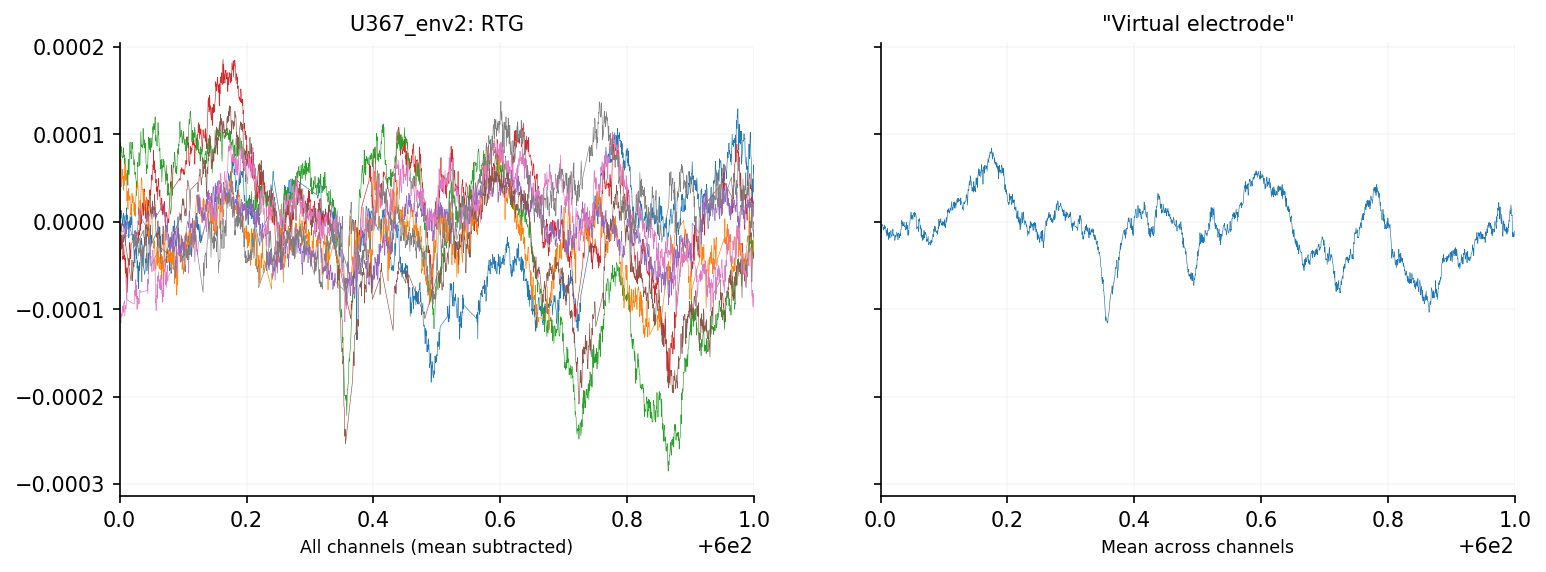

In [433]:
subj_sess = 'U367_env2'
roi = 'RTG'

subj_df_ = subj_df.loc[subj_df.subj_sess==subj_sess]
lfp = TimeSeries.from_hdf(os.path.join(data_dir, 'lfp', '{}_notch-filtered_spikes-interpolated.hdf'.format(subj_sess)))
loc_to_chan = OrderedDict(subj_df_.groupby('location', sort=False).chan.apply(list))
lfp.channel.data = [str(chan) for chan in lfp.channel.data]
cdat = lfp.sel(channel=loc_to_chan[roi]) - lfp.sel(channel=loc_to_chan[roi]).mean(dim='time')
vdat = TimeSeries.from_hdf(os.path.join(data_dir, 'virtual_lfp', '{}_{}_notch-filtered_spikes-interpolated.hdf'.format(subj_sess, roi)))

start = 600
duration = 1

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
ax = np.ravel(ax)

plot_trace(np.expand_dims(vdat, 0), start=start, duration=duration, x_lab='Mean across channels', 
           x_units='secs', fig=fig, ax=ax[1], title='"Virtual electrode"')

plot_trace(cdat, start=start, duration=duration, x_units='secs', x_lab='All channels (mean subtracted)', 
           fig=fig, ax=ax[0], title='{}: {}'.format(subj_sess, roi))

f = os.path.join(figure_dir, '{}_{}_virtual_electrode.png'.format(subj_sess, roi))
#fig.savefig(f)

(<Figure size 1800x600 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b1333919e80>],
       dtype=object))

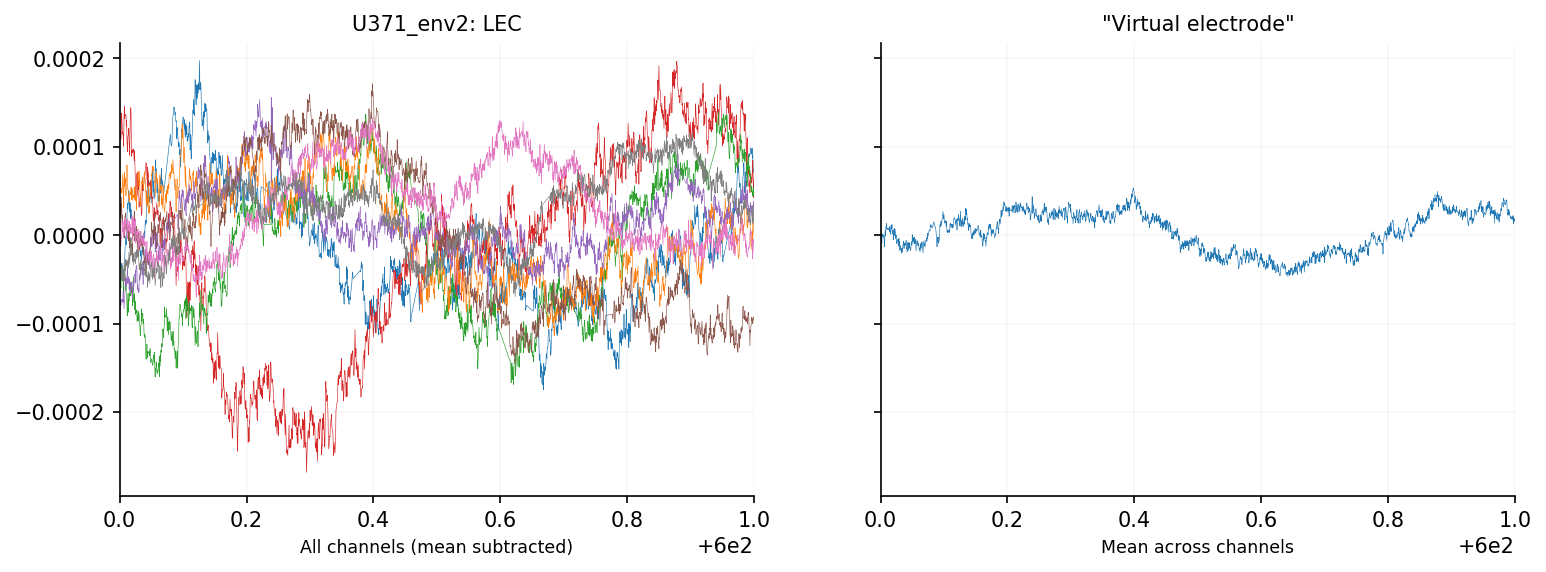

In [414]:
subj_sess, roi = random_subjroi(spike_rois)

subj_df_ = subj_df.loc[subj_df.subj_sess==subj_sess]
lfp = TimeSeries.from_hdf(os.path.join(data_dir, 'lfp', '{}_notch-filtered_spikes-interpolated.hdf'.format(subj_sess)))
loc_to_chan = OrderedDict(subj_df_.groupby('location', sort=False).chan.apply(list))
lfp.channel.data = [str(chan) for chan in lfp.channel.data]
cdat = lfp.sel(channel=loc_to_chan[roi]) - lfp.sel(channel=loc_to_chan[roi]).mean(dim='time')
vdat = TimeSeries.from_hdf(os.path.join(data_dir, 'virtual_lfp', '{}_{}_notch-filtered_spikes-interpolated.hdf'.format(subj_sess, roi)))

start = 600
duration = 1

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
ax = np.ravel(ax)

plot_trace(np.expand_dims(vdat, 0), start=start, duration=duration, x_lab='Mean across channels', 
           x_units='secs', fig=fig, ax=ax[1], title='"Virtual electrode"')

plot_trace(cdat, start=start, duration=duration, x_units='secs', x_lab='All channels (mean subtracted)', 
           fig=fig, ax=ax[0], title='{}: {}'.format(subj_sess, roi))

(<Figure size 1800x600 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b13337f9e80>],
       dtype=object))

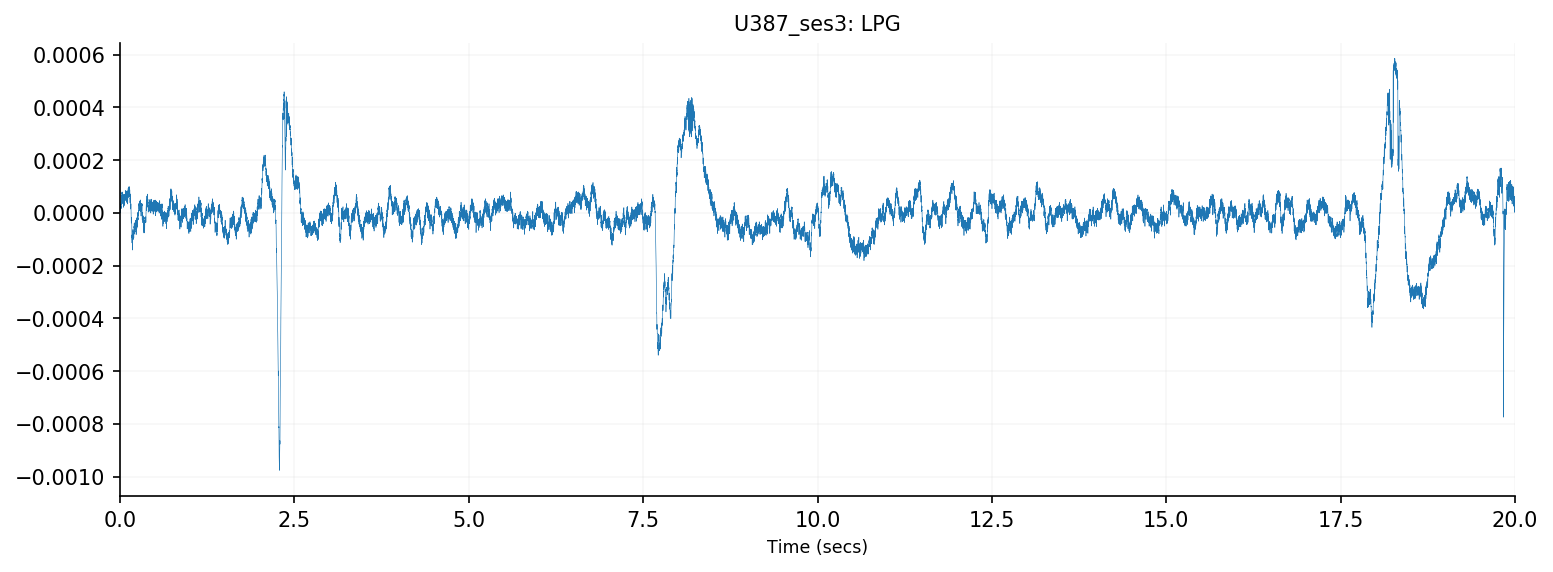

In [412]:
#subj_sess, roi = random_subjroi(spike_rois)
dat = TimeSeries.from_hdf(os.path.join(data_dir, 'virtual_lfp', '{}_{}_notch-filtered_spikes-interpolated.hdf'.format('U367_env2', 'RTG')))
plot_trace(np.expand_dims(dat, 0), start=0, duration=20, x_units='secs', title='{}: {}'.format(subj_sess, roi))

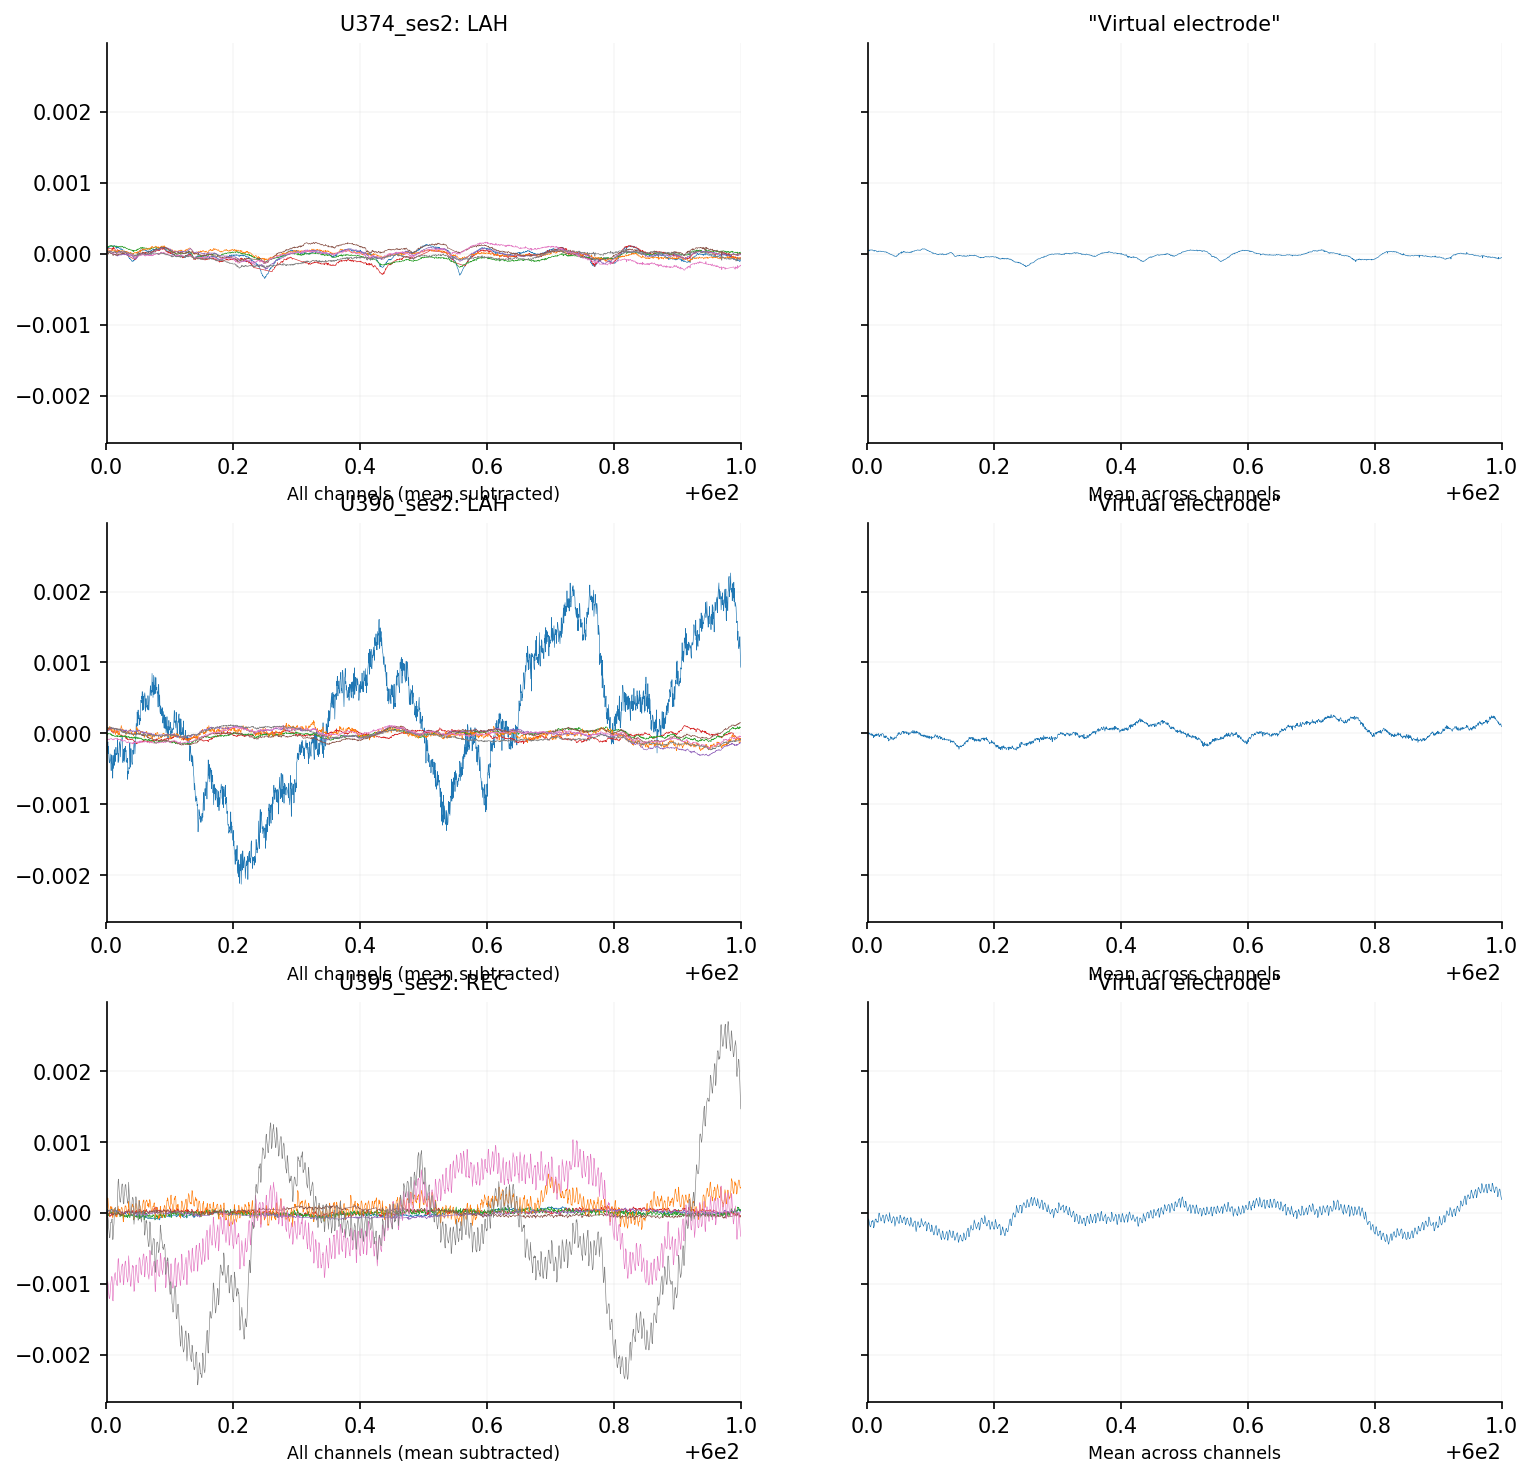

In [416]:
fig, ax = plt.subplots(3, 2, sharey=True, figsize=(12, 12))
ax = np.ravel(ax)
for i in range(3):
    subj_sess, roi = random_subjroi(spike_rois)

    subj_df_ = subj_df.loc[subj_df.subj_sess==subj_sess]
    lfp = TimeSeries.from_hdf(os.path.join(data_dir, 'lfp', '{}_notch-filtered_spikes-interpolated.hdf'.format(subj_sess)))
    loc_to_chan = OrderedDict(subj_df_.groupby('location', sort=False).chan.apply(list))
    lfp.channel.data = [str(chan) for chan in lfp.channel.data]
    cdat = lfp.sel(channel=loc_to_chan[roi]) - lfp.sel(channel=loc_to_chan[roi]).mean(dim='time')
    vdat = TimeSeries.from_hdf(os.path.join(data_dir, 'virtual_lfp', '{}_{}_notch-filtered_spikes-interpolated.hdf'.format(subj_sess, roi)))

    start = 600
    duration = 1
    
    plot_trace(np.expand_dims(vdat, 0), start=start, duration=duration, x_lab='Mean across channels', 
               x_units='secs', fig=fig, ax=ax[(2*i + 1)], title='"Virtual electrode"')

    plot_trace(cdat, start=start, duration=duration, x_units='secs', x_lab='All channels (mean subtracted)', 
               fig=fig, ax=ax[(2*i + 0)], title='{}: {}'.format(subj_sess, roi))

In [5]:
# Run morlet wavelets over each virtual electrode.
def run_morlet_parallel(virtual_chan):
    """Wrapper function for running morlet wavelets over virtual electrodes."""
    import os
    import sys
    sys.path.append('/home1/dscho/code/projects/manning_replication')
    import numpy as np
    import manning_analysis
    from ptsa.data.TimeSeriesX import TimeSeries 
    
    # Load the LFP data.
    subj_sess, roi = virtual_chan.split(', ')
    f = '/data3/scratch/dscho/frLfp/data/virtual_lfp/{}_{}_notch-filtered_spikes-interpolated.hdf'.format(subj_sess, roi)
    assert os.path.exists(f)
    lfp_proc = TimeSeries.from_hdf(f)
    lfp_proc = lfp_proc.expand_dims('channel', axis=0)
    
    # Select frequencies to get power and phase estimates for.
    freq_low = 2
    freq_high = 200
    freq_steps = 50
    
    freqs = np.logspace(np.log10(freq_low), np.log10(freq_high), freq_steps, base=10)
    for chan in lfp_proc.channel.data:
        power, phase = manning_analysis.run_morlet(
            lfp_proc,
            width=5, 
            freqs=freqs, 
            log_power=False, 
            z_power=False, 
            savedir='/data3/scratch/dscho/frLfp/data/virtual_lfp/morlet',
            power_file = '/data3/scratch/dscho/frLfp/data/virtual_lfp/morlet/{}_{}_power_width5_2-200Hz-50log10steps.hdf'.format(subj_sess, roi),
            overwrite=False
        )
        
    return None

In [105]:
# Get subj_sess and roi for all virtual electrodes.
virtual_chans = []
for subj_sess in spike_rois:
    for roi in spike_rois[subj_sess]:
        virtual_chans.append('{}, {}'.format(subj_sess, roi))
print('{} virtual chans'.format(len(virtual_chans)))
print(virtual_chans[:5])

281 virtual chans
['U367_env2, RTG', 'U367_env2, RAH', 'U367_env2, RPH', 'U367_env2, LA', 'U367_env2, LPH']


In [13]:
# Get subj_sess and roi for all virtual electrodes.
virtual_chans = []
for subj_sess in spike_rois:
    for roi in spike_rois[subj_sess]:
        output_f = os.path.join(data_dir, 'virtual_lfp', 'morlet', '{}_{}_power_width5_2-200Hz-50log10steps.hdf'.format(subj_sess, roi))
        if not os.path.exists(output_f):
            virtual_chans.append('{}, {}'.format(subj_sess, roi))
print('{} virtual chans'.format(len(virtual_chans)))
print(virtual_chans[:5])

7 virtual chans
['U374_ses1, LAH', 'U374_ses1, LAC', 'U384_ses1, LOF', 'U387_ses1, LEC', 'U387_ses1, LAC']


In [14]:
# Run channel w/o parallelizing.
start = time()
for virtual_chan in virtual_chans:
    run_morlet_parallel(virtual_chan)
print('Done in {:.0f} secs'.format(time() - start))

INFO:run_morlet:Calculating power and phase.


CPP total time wavelet loop:  21.4560809135437


INFO:run_morlet:Saving power and phase:
	/data3/scratch/dscho/frLfp/data/virtual_lfp/morlet/U374_ses1_LAH_power_width5_2-200Hz-50log10steps.hdf
	/data3/scratch/dscho/frLfp/data/virtual_lfp/morlet/U374_ses1_ch0_phase_width5_2-200Hz-50log10steps.hdf
INFO:run_morlet:Calculating power and phase.


CPP total time wavelet loop:  21.064801931381226


INFO:run_morlet:Saving power and phase:
	/data3/scratch/dscho/frLfp/data/virtual_lfp/morlet/U374_ses1_LAC_power_width5_2-200Hz-50log10steps.hdf
	/data3/scratch/dscho/frLfp/data/virtual_lfp/morlet/U374_ses1_ch0_phase_width5_2-200Hz-50log10steps.hdf
INFO:run_morlet:Calculating power and phase.


CPP total time wavelet loop:  20.475987434387207


INFO:run_morlet:Saving power and phase:
	/data3/scratch/dscho/frLfp/data/virtual_lfp/morlet/U384_ses1_LOF_power_width5_2-200Hz-50log10steps.hdf
	/data3/scratch/dscho/frLfp/data/virtual_lfp/morlet/U384_ses1_ch0_phase_width5_2-200Hz-50log10steps.hdf
INFO:run_morlet:Calculating power and phase.


CPP total time wavelet loop:  22.55417561531067


INFO:run_morlet:Saving power and phase:
	/data3/scratch/dscho/frLfp/data/virtual_lfp/morlet/U387_ses1_LEC_power_width5_2-200Hz-50log10steps.hdf
	/data3/scratch/dscho/frLfp/data/virtual_lfp/morlet/U387_ses1_ch0_phase_width5_2-200Hz-50log10steps.hdf
INFO:run_morlet:Calculating power and phase.


CPP total time wavelet loop:  22.469375133514404


INFO:run_morlet:Saving power and phase:
	/data3/scratch/dscho/frLfp/data/virtual_lfp/morlet/U387_ses1_LAC_power_width5_2-200Hz-50log10steps.hdf
	/data3/scratch/dscho/frLfp/data/virtual_lfp/morlet/U387_ses1_ch0_phase_width5_2-200Hz-50log10steps.hdf
INFO:run_morlet:Calculating power and phase.


CPP total time wavelet loop:  13.686150074005127


INFO:run_morlet:Saving power and phase:
	/data3/scratch/dscho/frLfp/data/virtual_lfp/morlet/U387_ses3_LAC_power_width5_2-200Hz-50log10steps.hdf
	/data3/scratch/dscho/frLfp/data/virtual_lfp/morlet/U387_ses3_ch0_phase_width5_2-200Hz-50log10steps.hdf
INFO:run_morlet:Calculating power and phase.


CPP total time wavelet loop:  21.71406126022339


INFO:run_morlet:Saving power and phase:
	/data3/scratch/dscho/frLfp/data/virtual_lfp/morlet/U393_ses2_LST_power_width5_2-200Hz-50log10steps.hdf
	/data3/scratch/dscho/frLfp/data/virtual_lfp/morlet/U393_ses2_ch0_phase_width5_2-200Hz-50log10steps.hdf


Done in 336 secs


In [12]:
print('Running morlet wavelets for {} virtual electrodes.'.format(len(virtual_chans)))
print('Starting clusters.')
queue = ['RAM.q', 'matlab.q']
with cluster_view(scheduler='sge', queue=queue[0], num_jobs=len(virtual_chans), 
                  cores_per_job=1, extra_params={'mem':32}) as view: 
    output = view.map(run_morlet_parallel, virtual_chans)

Running morlet wavelets for 19 virtual electrodes.
Starting clusters.
0 Engines running

DEBUG:asyncio:Using selector: EpollSelector


19 Engines running

DEBUG:asyncio:Using selector: EpollSelector



Sending a shutdown signal to the controller and engines.


OSError: [Errno 16] Device or resource busy: '.nfs000000310327e01b00068a8e'

In [460]:
subj_sess = 'U367_env2'
roi = 'RTG'
power = TimeSeries.from_hdf(os.path.join(data_dir, 'virtual_lfp', 'morlet', 
                                         '{}_{}_power_width5_2-200Hz-50log10steps.hdf'.format(subj_sess, roi)))
power = power.squeeze()

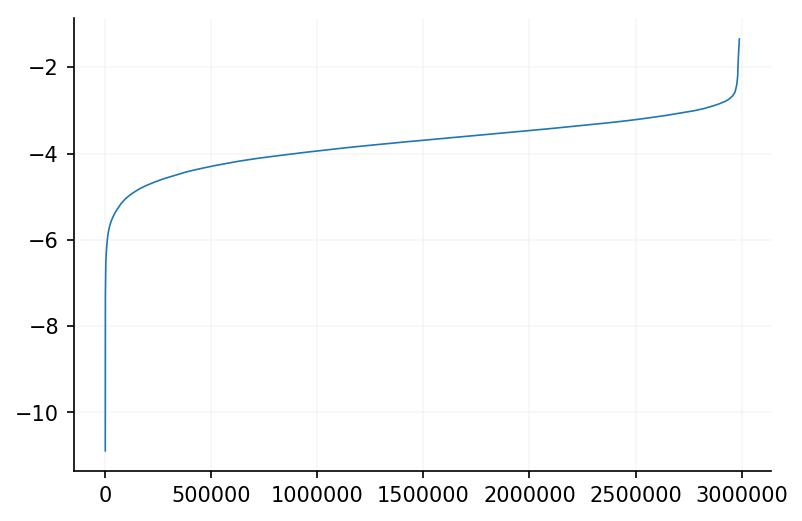

In [464]:
def epoch_fr_power(subj_sess,
                   lfp_proc, 
                   fr_df,
                   chan_to_clus,
                   chans=None,
                   log_power=False,
                   z_power='',
                   freq_params={'low': 2, 'high': 200, 'num': 50}, 
                   epoch_size=1000, 
                   epoch_cut=3,
                   input_dir='/data3/scratch/dscho/frLfp/data/lfp/morlet',
                   output_dir='/data3/scratch/dscho/frLfp/data/epoch',
                   power_file_suffix='_width5_2-200Hz-50log10steps',
                   load_existing=True,
                   save_files=False,
                   log_dir='/data3/scratch/dscho/frLfp/logs'):
    """Divide each channel into epochs, and calculate the mean firing rate and
    power (at each frequency) within each epoch.
    
    Also calculate narrowband and broadband power for each epoch, using a
    robust regression model for the latter.
    
    Parameters
    ----------
    subj_sess : str
        e.g. 'U367_env2'
    lfp_proc : ptsa.data.timeseries.TimeSeries
        An n_channels x n_timepoints TimeSeries of the processed LFP data.
    fr_df : pandas.core.frame.DataFrame
        A DataFrame version of session_spikes, of sorts. n_clusters long and
        stores spikes, fr, and interp_mask for each cluster across all channels 
        in the session, along with some metadata.
    chan_to_clus : collections.OrderedDict
        Mapping between each unique channel in the recording session and a list
        of corresponding (across channel) cluster numbers (only has keys for
        channels with spikes!).
    chans : list or numpy.ndarray
        A list of channel names to process. Default is to use 
        all channels in lfp_proc.
    log_power : bool
        If True, power values are log10 transformed after epoching.
    z_power : str
        'withinfreq' -- Power values are Z-scored across epochs, 
            separately for each frequency.
        'acrossfreq' -- Power values are Z-scored across epochs 
            and frequencies. 
        Transform is applied after epoching. If log_power is True, 
        log transform is done before Z-scoring.
    freq_params : dict
        Keys must be 'low', 'high', and 'num'. Gives the frequency
        range and number of frequencies used in calculating power
        from LFP data through Morlet decomposition.
    epoch_size : int
        The number of timepoints that will comprise each epoch.
    epoch_cut : int
        The number of epochs to cut from the beginning and end
        of the recording session (to remove edge effects).
    input_dir : str
        Directory where input data are loaded.
    output_dir : str
        Directory where output files are loaded/saved.
    power_file_suffix : str
        The suffix to use in selecting power files to load from
        input_dir.
    load_existing : bool
        If True and output files exist, load and return them
        rather than reprocessing epochs.
    save_files : bool
        If True, output TimeSeries objects are saved as hdf5 files.
        If files already exist, load_existing is False, and save_files
        is True, then existing files are overwritten!
    log_dir : str
        Directory where the log file is saved.
        
    Returns
    -------
    epoch_fr : ptsa.data.timeseries.TimeSeries
        Mean firing rate for each epoch, for each cluster in the
        session. Dims are cluster x epoch.
    epoch_power : ptsa.data.timeseries.TimeSeries
        Mean power for each frequency, for each epoch, for each
        channel in the session. Dims are channel x epoch x freq.
    epoch_band_power : ptsa.data.timeseries.TimeSeries
        Mean power for frequencies within delta, theta, alpha, beta,
        and gamma bands; along with the slope and intercept of a robust
        robust regression model predicting power at each frequency for
        a given channel/epoch. Broadband power is also reported as the
        mean predicted value from the regression fit. Dims are 
        channel x epoch x freq.
    """
    # Setup logging.
    logger = logging.getLogger(sys._getframe().f_code.co_name)
    logger.handlers = []
    log_f = os.path.join(log_dir, '{}_{}_{}.log'.format(subj_sess, 
                                                        sys._getframe().f_code.co_name, 
                                                        strftime('%m-%d-%Y-%H-%M-%S')))
    handler = logging.FileHandler(log_f)
    handler.setLevel(logging.DEBUG)
    formatting = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s', 
                                   datefmt='%m-%d-%Y %H:%M:%S')
    handler.setFormatter(formatting)
    logger.addHandler(handler)
    
    # Load epoched data if it exists.
    # -----------------------------------
    
    # Generate tag to explain processing steps (done in L->R order).
    fstr = ''
    if log_power:
        fstr += '_log10'
    if z_power:
        fstr += '_Z-{}'.format(z_power)
    if lfp_proc.samplerate >= epoch_size:
        epoch_rate_str = '{:.0f}'.format(lfp_proc.samplerate.data / epoch_size)
    else:
        epoch_rate_str = '{:.02f}'.format(lfp_proc.samplerate.data / epoch_size)
    process_tag = ('power' + power_file_suffix 
                   + '_epoch-{}Hz-cut{}'.format(epoch_rate_str, epoch_cut)
                   + fstr)
    
    epoch_fr_file = os.path.join(output_dir, '{}_fr_epoch-{}Hz-cut{}.hdf'
                                 .format(subj_sess, epoch_rate_str, epoch_cut))
    epoch_power_file = os.path.join(output_dir, '{}_{}.hdf'.format(subj_sess, process_tag))
    epoch_band_power_file = os.path.join(output_dir, '{}_{}_freqbands.hdf'.format(subj_sess, process_tag))
    files_exist = (os.path.exists(epoch_fr_file) 
                   and os.path.exists(epoch_power_file) 
                   and os.path.exists(epoch_band_power_file))
    if files_exist and load_existing:
        logger.info('Loading epoched spike and power data.')
        epoch_fr = TimeSeries.from_hdf(epoch_fr_file)
        epoch_power = TimeSeries.from_hdf(epoch_power_file)
        epoch_band_power = TimeSeries.from_hdf(epoch_band_power_file)
        return epoch_fr, epoch_power, epoch_band_power
    
    # Process data into epochs.
    # -------------------------
    start_time = time()
    logger.info('Processing spike and power data into epochs.')
    
    # Get channels and corresponding clusters to process.
    if chans is None:
        chans = lfp_proc.channel.data
    clusters = []
    for chan in chans:
        if chan in chan_to_clus.keys():
            clusters += chan_to_clus[chan]
    
    # Get time bins to divide the data into 500ms epochs, cutting
    # out the first and last (+remainder) 3000 timepoints (1500ms).
    n_timepoints = lfp_proc.shape[1]    
    time_bins = manning_utils.get_epochs(np.arange(n_timepoints, dtype=np.int32), 
                                         epoch_size=epoch_size, 
                                         cut=epoch_cut)

    # Get wavelet frequencies and assign them to bands of interest.
    freqs, freq_bands = manning_utils.get_freqs(low=freq_params['low'], 
                                                high=freq_params['high'], 
                                                num=freq_params['num'])
    # X is the independent variable for the robust regression.
    X = sm.add_constant(np.log10(freqs))
    
    # Get the mean firing rate for each epoch, for each cluster.
    # ----------------------------------------------------------
    epoch_fr = []
    cluster_channels = []
    cluster_locs = []
    for clus in clusters:
        # Get the mean firing rate (in Hz) for each epoch.
        cluster_channels.append(fr_df.loc[fr_df.clus==clus, 'chan'].iat[0])
        cluster_locs.append(fr_df.loc[fr_df.clus==clus, 'location'].iat[0])
        clus_fr = fr_df.loc[fr_df.clus==clus, 'fr'].iat[0]
        epoch_fr_row = []
        for epoch_start, epoch_stop in time_bins:
            epoch_fr_row.append(2 * np.sum(clus_fr[epoch_start:epoch_stop]))
        epoch_fr.append(epoch_fr_row)

    epoch_fr = TimeSeries(np.array(epoch_fr), name=lfp_proc.name,
                          dims=['cluster', 'epoch'],
                          coords={'cluster': clusters,
                                  'epoch': np.arange(len(time_bins)),
                                  'samplerate': lfp_proc.samplerate.data / epoch_size},
                          attrs={'epoch_bins': time_bins,
                                 'channel': cluster_channels,
                                 'location': cluster_locs})
    
    # Get narrowband and broadband power for each epoch, for each channel.
    # --------------------------------------------------------------------
    epoch_power = []
    epoch_band_power = []
    for i, chan in enumerate(chans):
        if i % 8 == 0:
            logger.info('Loading power data for {} channel {}.'.format(subj_sess, chan))
        f = os.path.join(input_dir, '{}_ch{}_power{}.hdf'.format(subj_sess, chan, power_file_suffix))
        power = TimeSeries.from_hdf(f).data.squeeze() # frequency x time
        epoch_power_row = []
        epoch_band_power_row = []
        # For timepoints in each epoch, get the mean power over time, 
        # at each frequency.
        for epoch_start, epoch_stop in time_bins:
            epoch_power_row.append(np.mean(power[:, epoch_start:epoch_stop], axis=1))
        
        epoch_power_row = np.array(epoch_power_row) # n_epochs x n_freqs
        
        # Transform epoched power values.
        if log_power:
            epoch_power_row = np.log10(epoch_power_row)
            if i == 0:
                logger.info('Log transforming epoched power values.')
        if z_power == 'withinfreq':
            epoch_power_row = (epoch_power_row - np.mean(epoch_power_row, axis=0)) / np.std(epoch_power_row, axis=0)
            if i == 0:
                logger.info('Z-scoring epoched power values within each frequency.')
        elif z_power == 'acrossfreq':
            epoch_power_row = (epoch_power_row - np.mean(epoch_power_row)) / np.std(epoch_power_row)
            if i == 0:
                logger.info('Z-scoring epoched power values across frequencies.')
            
        for epoch in range(epoch_power_row.shape[0]):
            # Get mean delta, theta, alpha, beta, and gamma power.   
            delta_power = np.mean(epoch_power_row[epoch, (freqs<4)])
            theta_power = np.mean(epoch_power_row[epoch, (freqs>=4) & (freqs<8)])
            alpha_power = np.mean(epoch_power_row[epoch, (freqs>=8) & (freqs<12)])
            beta_power = np.mean(epoch_power_row[epoch, (freqs>=12) & (freqs<30)])
            gamma_power = np.mean(epoch_power_row[epoch, (freqs>=30)])

            # Fit a robust linear regression to estimate the intercept 
            # and slope (broadband tilt) of the power spectrum. Broadband
            # power is the mean of the predicted values.
            y = epoch_power_row[epoch, :]
            huber_t = sm.RLM(y, X, M=sm.robust.norms.HuberT())
            hub_results = huber_t.fit()
            intercept, slope = hub_results.params
            epoch_band_power_row.append(
                    [delta_power, theta_power, alpha_power, beta_power, gamma_power, 
                     intercept, slope, np.mean(hub_results.predict())]
                )

        epoch_power.append(epoch_power_row) # n_channels x n_epochs x n_freqs
        epoch_band_power.append(epoch_band_power_row) # n_channels x n_epochs x (n_freq_bands + 3)

    epoch_power = TimeSeries(np.array(epoch_power), name=lfp_proc.name, 
                             dims=['channel', 'epoch', 'freq'],
                             coords={'channel': chans,
                                     'epoch': np.arange(len(time_bins)),        
                                     'freq': freqs,
                                     'samplerate': lfp_proc.samplerate.data / epoch_size},
                             attrs={'epoch_bins': time_bins,
                                    'process_tag': process_tag})
    
    epoch_band_power = TimeSeries(np.array(epoch_band_power), name=lfp_proc.name, 
                                  dims=['channel', 'epoch', 'freq'],
                                  coords={'channel': chans,
                                          'epoch': np.arange(len(time_bins)),        
                                          'freq': (list(freq_bands.keys()) 
                                                   + ['intercept', 'bband_tilt', 'bband_power']),
                                          'samplerate': lfp_proc.samplerate.data / epoch_size},
                                  attrs={'epoch_bins': time_bins,
                                         'process_tag': process_tag})
    
    if save_files:
        epoch_fr.to_hdf(epoch_fr_file)
        epoch_power.to_hdf(epoch_power_file)
        epoch_band_power.to_hdf(epoch_band_power_file)
        logger.info('Saved epoched data to files:\n\t{}\n\t{}\n\t{}.'
                     .format(epoch_fr_file, epoch_power_file, epoch_band_power_file))

    duration = time() - start_time
    logger.info('Done in {} secs.'.format(int(duration)))
        
    return epoch_fr, epoch_power, epoch_band_power